In [ ]:
!rm -rf sample_data/ #extra space freeing

In [ ]:
# Load dataset from google drive folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "SCUT_FBP5500_downsampled.zip"

Streaming output truncated to the last 5000 lines.
  inflating: test/3_AM653.jpg        
  inflating: test/3_AM666.jpg        
  inflating: test/3_AM682.jpg        
  inflating: test/3_AM702.jpg        
  inflating: test/3_AM716.jpg        
  inflating: test/3_AM741.jpg        
  inflating: test/3_AM751.jpg        
  inflating: test/3_AM767.jpg        
  inflating: test/3_AM780.jpg        
  inflating: test/3_AM794.jpg        
  inflating: test/3_AM810.jpg        
  inflating: test/3_AM827.jpg        
  inflating: test/3_AM837.jpg        
  inflating: test/3_AM848.jpg        
  inflating: test/3_AM865.jpg        
  inflating: test/3_AM884.jpg        
  inflating: test/3_AM899.jpg        
  inflating: test/3_AM909.jpg        
  inflating: test/3_AM919.jpg        
  inflating: test/3_AM933.jpg        
  inflating: test/3_AM954.jpg        
  inflating: test/3_AM978.jpg        
  inflating: test/3_AM989.jpg        
  inflating: test/3_AM998.jpg        
  inflating: test/3_CF115.jpg        

# Dataset Loading

In [ ]:
import tensorflow as tf
import os

def parse_label_from_path(path):
    fname = tf.strings.regex_replace(path, r".*[\\/]", "")          # -> b"7_CM668.jpg"
    # 2) grab the leading integer before the underscore
    num   = tf.strings.regex_replace(fname, r"^([0-9]+)_.*$", r"\1")# -> b"7"
    # 3) to float and shape (1,) for regression
    label = tf.strings.to_number(num, out_type=tf.float32)
    return tf.reshape(label, [1])  # regression target shape [1]

def process_img(path):
    img = tf.io.decode_jpeg(tf.io.read_file(path), channels=3)
    img = tf.image.resize(img, (80, 80)) / 255.0
    y = parse_label_from_path(path)
    return img, y  # <-- (features, label)

train_dataset = (tf.data.Dataset.list_files("training/*.jpg")).map(process_img).prefetch(tf.data.AUTOTUNE)
validation_dataset = (tf.data.Dataset.list_files("validation/*.jpg")).map(process_img).prefetch(tf.data.AUTOTUNE)

Checking the dataset whether it is correct

In [ ]:
import tensorflow as tf

print("train cardinality:", tf.data.experimental.cardinality(train_dataset))
print("val cardinality  :", tf.data.experimental.cardinality(validation_dataset))
print("test cardinality :", tf.data.experimental.cardinality(test_dataset))

for xb, yb in train_dataset.batch(32).take(1):
    print("first train batch:", xb.shape, yb.shape)
for xb, yb in train_dataset.batch(32).skip(111).take(1):  # last step
    print("last  train batch:", xb.shape, yb.shape)       # expect (3, 80, 80, 3)

train cardinality: tf.Tensor(3555, shape=(), dtype=int64)
val cardinality  : tf.Tensor(893, shape=(), dtype=int64)


NameError: name 'test_dataset' is not defined

In [ ]:
# Check if tensorflow is using GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
%ls training | wc -l
%ls validation | wc -l
%ls test | wc -l

3555
893
895


Sample numbers are correct for training validation
Input image dimensions are correct B,H,W,C and 1 dimension for

In [ ]:
def dataset_stats(ds, batch_size=32):
    """
    Computes min, max, mean, std for images and labels.
    - Assumes each element is (image, label) with image float in [0,1] and label shape (1,) or ().
    - Returns dict with global image stats (over all pixels) and per-channel stats,
      and label stats (over samples).
    """
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Global image stats (all pixels), and per-channel stats
    img_min = tf.constant(float('inf'), tf.float32)
    img_max = tf.constant(float('-inf'), tf.float32)
    img_sum = tf.constant(0.0, tf.float32)
    img_sumsq = tf.constant(0.0, tf.float32)
    img_count = tf.constant(0.0, tf.float32)

    ch_sum = None
    ch_sumsq = None
    ch_count = None

    # Label stats (per sample)
    y_min = tf.constant(float('inf'), tf.float32)
    y_max = tf.constant(float('-inf'), tf.float32)
    y_sum = tf.constant(0.0, tf.float32)
    y_sumsq = tf.constant(0.0, tf.float32)
    y_count = tf.constant(0.0, tf.float32)

    for xb, yb in ds:
        # Ensure float32
        xb = tf.cast(xb, tf.float32)
        yb = tf.cast(yb, tf.float32)

        # ----- images: global -----
        img_min = tf.minimum(img_min, tf.reduce_min(xb))
        img_max = tf.maximum(img_max, tf.reduce_max(xb))
        img_sum += tf.reduce_sum(xb)
        img_sumsq += tf.reduce_sum(tf.square(xb))
        img_count += tf.cast(tf.size(xb), tf.float32)

        # ----- images: per-channel -----
        # reduce over N, H, W; keep C
        ch_axes = [0, 1, 2]  # assuming NHWC
        cur_ch_sum = tf.reduce_sum(xb, axis=ch_axes)         # shape (C,)
        cur_ch_sumsq = tf.reduce_sum(tf.square(xb), axis=ch_axes)  # (C,)
        cur_ch_count = tf.cast(tf.reduce_prod(tf.shape(xb)[:3]), tf.float32)  # N*H*W
        if ch_sum is None:
            ch_sum = cur_ch_sum
            ch_sumsq = cur_ch_sumsq
            ch_count = cur_ch_count
        else:
            ch_sum += cur_ch_sum
            ch_sumsq += cur_ch_sumsq
            ch_count += cur_ch_count

        # ----- labels -----
        y_min = tf.minimum(y_min, tf.reduce_min(yb))
        y_max = tf.maximum(y_max, tf.reduce_max(yb))
        y_sum += tf.reduce_sum(yb)
        y_sumsq += tf.reduce_sum(tf.square(yb))
        y_count += tf.cast(tf.size(yb), tf.float32)  # count of label scalars

    # finalize
    img_mean = img_sum / tf.maximum(img_count, 1.0)
    img_var = tf.maximum(img_sumsq / tf.maximum(img_count, 1.0) - tf.square(img_mean), 0.0)
    img_std = tf.sqrt(img_var)

    ch_mean = ch_sum / tf.maximum(ch_count, 1.0) if ch_sum is not None else None
    ch_var = tf.maximum(ch_sumsq / tf.maximum(ch_count, 1.0) - tf.square(ch_mean), 0.0) if ch_sum is not None else None
    ch_std = tf.sqrt(ch_var) if ch_var is not None else None

    y_mean = y_sum / tf.maximum(y_count, 1.0)
    y_var = tf.maximum(y_sumsq / tf.maximum(y_count, 1.0) - tf.square(y_mean), 0.0)
    y_std = tf.sqrt(y_var)

    return {
        "image_global": {"min": float(img_min.numpy()),
                         "max": float(img_max.numpy()),
                         "mean": float(img_mean.numpy()),
                         "std":  float(img_std.numpy())},
        "image_per_channel": None if ch_sum is None else {
            "mean": ch_mean.numpy().tolist(),
            "std":  ch_std.numpy().tolist(),
        },
        "labels": {"min": float(y_min.numpy()),
                   "max": float(y_max.numpy()),
                   "mean": float(y_mean.numpy()),
                   "std":  float(y_std.numpy())}
    }

# ---- run on your datasets (unbatched ds expected) ----
train_stats = dataset_stats(train_dataset, batch_size=32)
val_stats   = dataset_stats(validation_dataset, batch_size=32)

print("TRAIN image (global):", train_stats["image_global"])
print("TRAIN image (per-channel RGB):", train_stats["image_per_channel"])
print("TRAIN labels:", train_stats["labels"])

print("VAL image (global):", val_stats["image_global"])
print("VAL image (per-channel RGB):", val_stats["image_per_channel"])
print("VAL labels:", val_stats["labels"])


TRAIN image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.49452918767929077, 'std': 0.29457250237464905}
TRAIN image (per-channel RGB): {'mean': [0.6062124371528625, 0.4732198119163513, 0.404154896736145], 'std': [0.32396456599235535, 0.2707997262477875, 0.2468574047088623]}
TRAIN labels: {'min': 1.0, 'max': 8.0, 'mean': 4.056540012359619, 'std': 1.9739253520965576}
VAL image (global): {'min': 0.0, 'max': 1.0, 'mean': 0.4917309284210205, 'std': 0.2933064103126526}
VAL image (per-channel RGB): {'mean': [0.6028154492378235, 0.4702853858470917, 0.40209218859672546], 'std': [0.3219274878501892, 0.26971346139907837, 0.24671490490436554]}
VAL labels: {'min': 1.0, 'max': 8.0, 'mean': 4.053751468658447, 'std': 1.975612759590149}


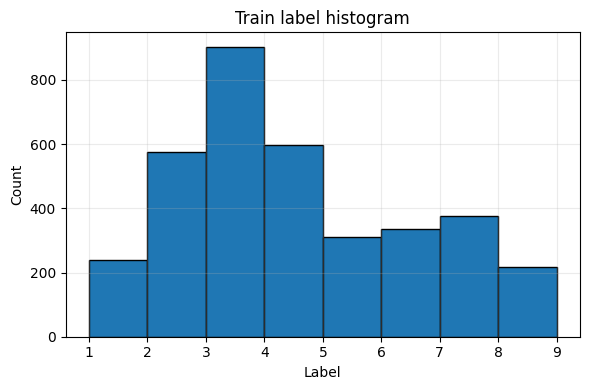

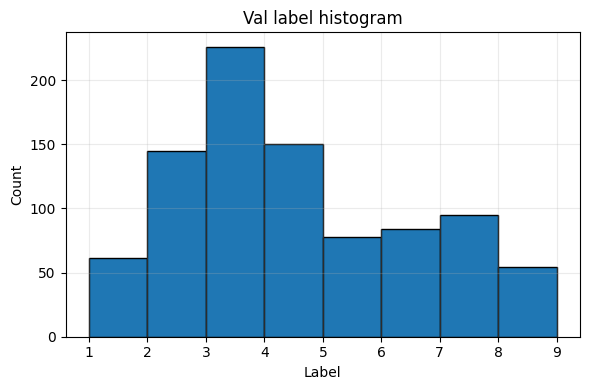

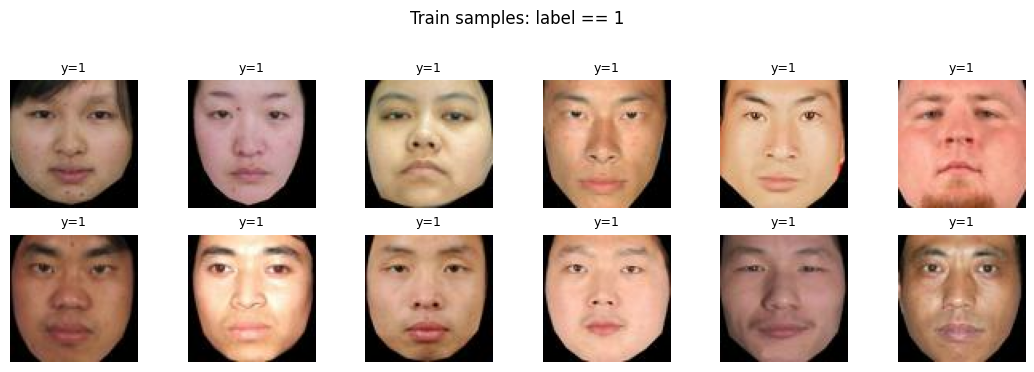

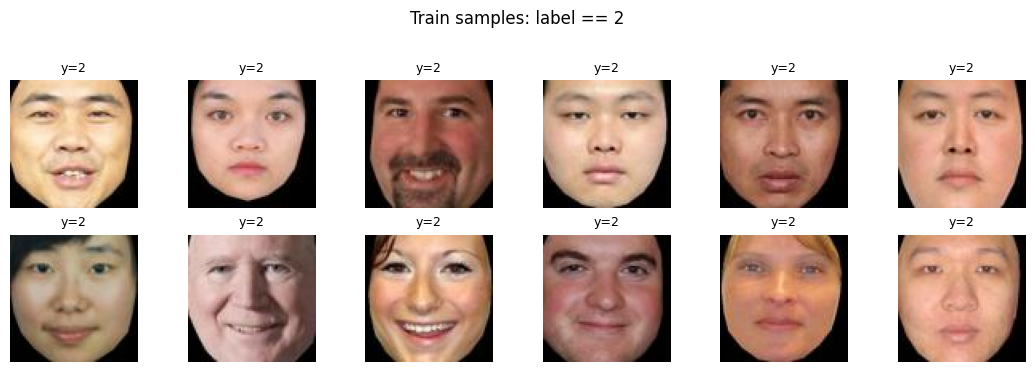

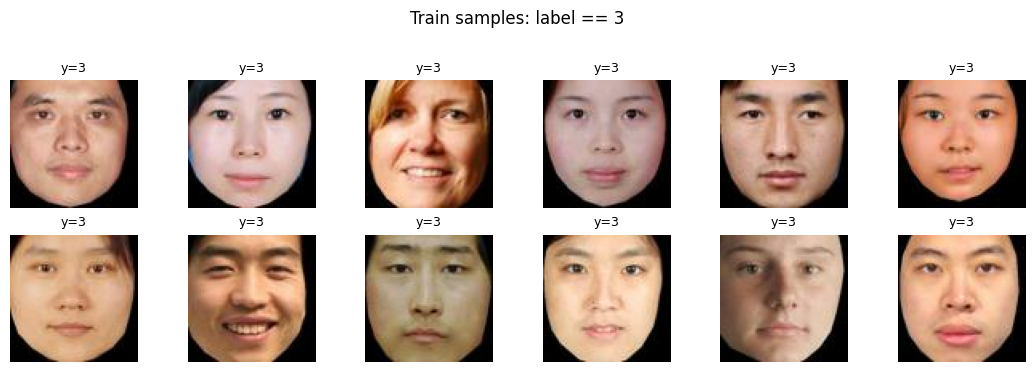

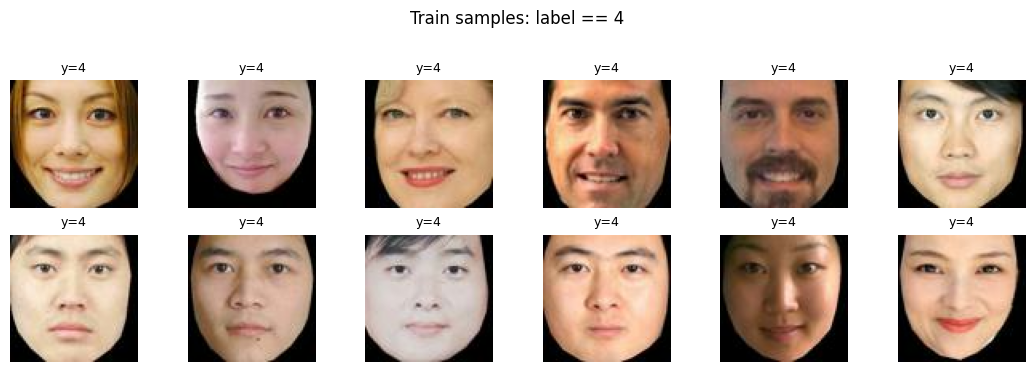

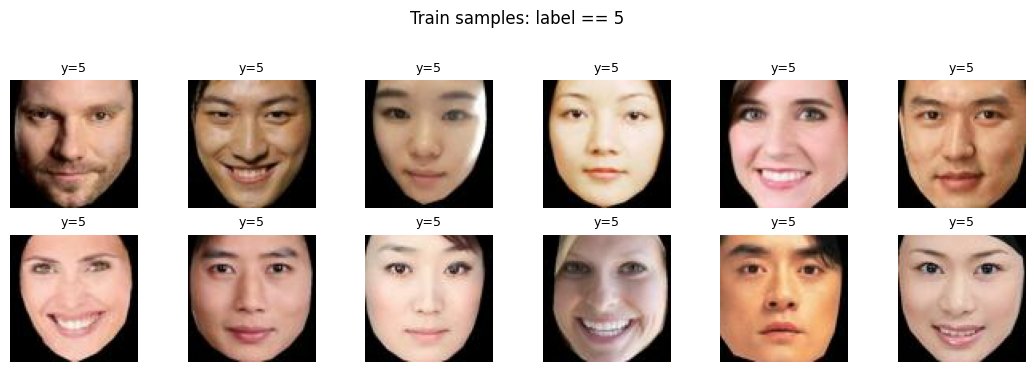

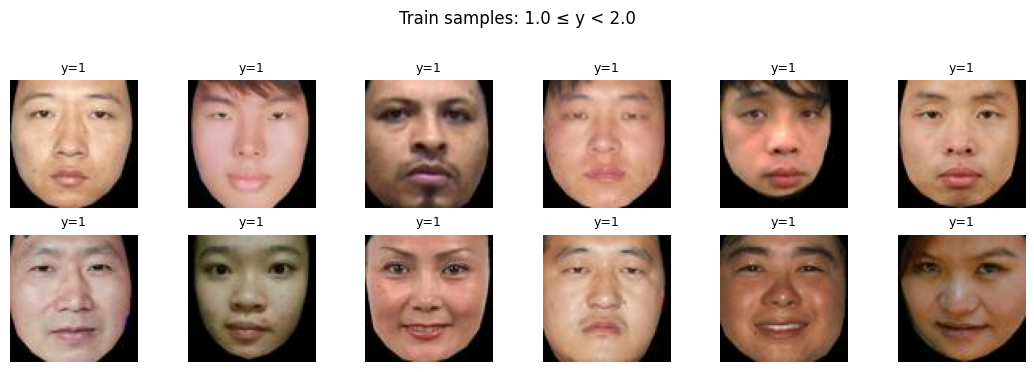

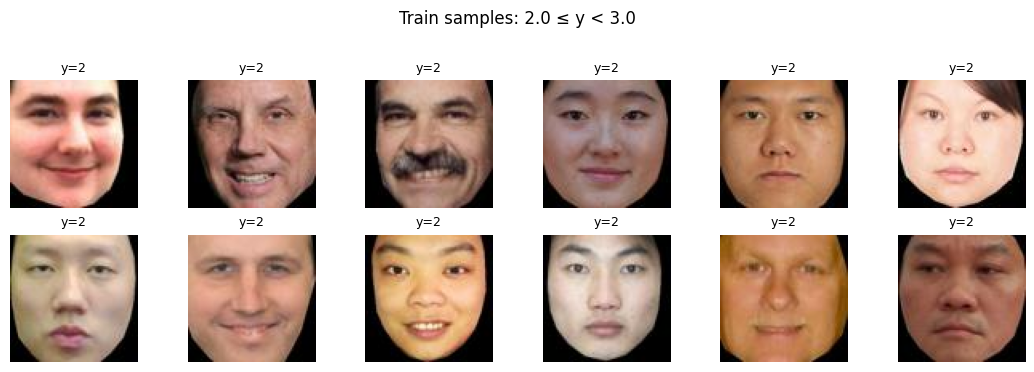

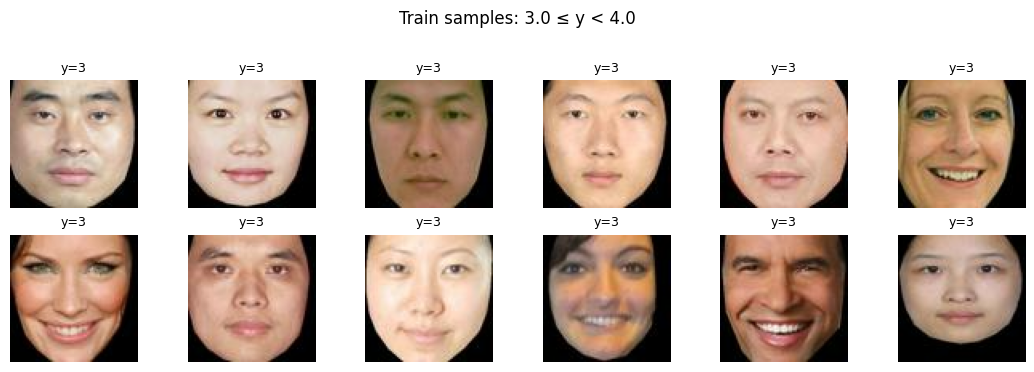

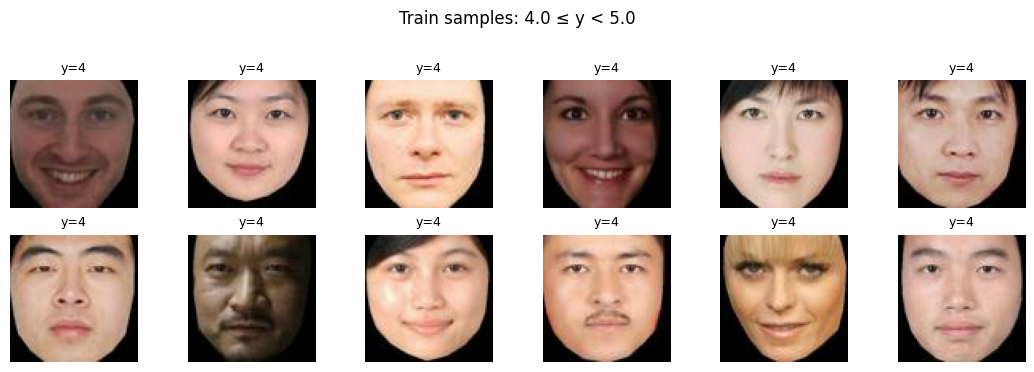

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
def plot_label_histogram(ds, title="Label histogram", bins=None, max_samples=None):
    labels = []
    n = 0
    for _, y in ds:
        y = tf.reshape(y, []).numpy().item()  # scalar
        labels.append(y)
        n += 1
        if max_samples is not None and n >= max_samples:
            break

    plt.figure(figsize=(6,4))
    if bins is None:
        # SCUT-FBP5500 labels are integers, usually 1..5. Force integer bins if desired.
        min_l, max_l = int(min(labels)), int(max(labels))
        bins = range(min_l, max_l + 2)  # inclusive edges for integers
    plt.hist(labels, bins=bins, edgecolor="black")
    plt.xlabel("Label"); plt.ylabel("Count"); plt.title(title)
    plt.grid(alpha=0.25)
    plt.tight_layout()
    plt.show()

# Usage:
plot_label_histogram(train_dataset, title="Train label histogram", max_samples=100000)
plot_label_histogram(validation_dataset, title="Val label histogram")
def _collect_examples(ds, predicate, k):
    """Collect up to k examples (img,y) where predicate(y) is True."""
    bucket = []
    for img, y in ds.shuffle(2048):
        y = tf.reshape(y, []).numpy().item()
        if predicate(y):
            bucket.append((img.numpy(), y))
            if len(bucket) >= k:
                break
    return bucket

def sample_by_label_equal(ds, target_label, k=8):
    """Sample images whose label == target_label (int)."""
    return _collect_examples(ds, lambda y: int(round(y)) == int(target_label), k)

def sample_by_label_range(ds, lo, hi, k=8, inclusive_right=False):
    """Sample images with lo <= y < hi  (or <= hi if inclusive_right)."""
    if inclusive_right:
        return _collect_examples(ds, lambda y: (y >= lo) and (y <= hi), k)
    return _collect_examples(ds, lambda y: (y >= lo) and (y < hi), k)

def show_grid(examples, title="", cols=8):
    if not examples:
        print("No examples to show.")
        return
    imgs = [e[0] for e in examples]
    ys   = [e[1] for e in examples]
    rows = int(np.ceil(len(imgs)/cols))
    plt.figure(figsize=(1.8*cols, 1.8*rows))
    for i, (im, y) in enumerate(zip(imgs, ys)):
        ax = plt.subplot(rows, cols, i+1)
        ax.imshow(np.clip(im, 0, 1))
        ax.set_title(f"y={int(round(y))}", fontsize=9)
        ax.axis("off")
    plt.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()
for L in [1, 2, 3, 4, 5]:
    exs = sample_by_label_equal(train_dataset, L, k=12)
    show_grid(exs, title=f"Train samples: label == {L}", cols=6)
bins = [(1.0,2.0), (2.0,3.0), (3.0,4.0), (4.0,5.0)]
for lo, hi in bins:
    exs = sample_by_label_range(train_dataset, lo, hi, k=12)
    show_grid(exs, title=f"Train samples: {lo} ≤ y < {hi}", cols=6)


# Model Creation

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  plt.figure()
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history.get("val_loss", []), label="val")
  plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
  plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as L, Model
class AttractRegressorModel(Model):
    def __init__(self, architecture:dict):
        super().__init__()
        self.architecture = architecture
        self.layer_list = self._build_model(architecture)
        self.is_sequential = self.architecture.get("computation_sequence", "sequential") == "sequential"
        if self.is_sequential:
          self.layer_list = tf.keras.Sequential(self.layer_list)
        #for residuality
        self.residual_map = {}
        self.required_outputs = set()
        if not self.is_sequential:
            self._parse_computation_sequence()

    def _parse_computation_sequence(self, architecture):
        computation_sequence = self.architecture.get("computation_sequence")
        for conn_str in computation_sequence:
            try:
                start, end = map(int, conn_str.split('-'))
                if start >= end:
                    raise ValueError(f"Start index ({start}) must be less than end index ({end}) in connection '{conn_str}'.")

                # Map the end point to the start point for quick lookups
                self.residual_map[end] = start

                # We need to store the output of the layer *before* the start index
                self.required_outputs.add(start - 1)
                print(f"  - Will add output of layer {start - 1} to output of layer {end}")

            except ValueError as e:
                raise ValueError(f"Invalid connection format: '{conn_str}'. Expected 'start-end'. Details: {e}")

    def _build_cnn_layer(self,params):
      return L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            kernel_initializer=params.get("initialization", "he_normal"),
            kernel_regularizer=tf.keras.regularizers.l2(params.get("l2_rate", 0)), # Zero means no regularizer
            use_bias=True
        ) if "dilation" not in params else L.Conv2D(
            filters=params["out_channels"],
            kernel_size=params.get("kernel_size", 3),
            padding=params.get("padding", "same"),
            dilation_rate=params.get("dilation", 1),
            use_bias=True
        )

    def _build_maxpool_layer(self,params):
      return L.MaxPooling2D(
            pool_size=params.get("pool_size", 2),
            strides=params.get("strides", 2)
        )

    def _build_batchnorm_layer(self,layer):
      return L.BatchNormalization()

    def _build_activation_layer(self, params: dict):
        name = params.get("name", "relu").lower()
        if name == 'leakyrelu':
            return L.LeakyReLU(alpha=params.get("alpha", 0.1))
        return L.Activation(name)

    def _build_dropout_layer(self, params):
      return L.Dropout(rate=params.get("rate", 0.5))

    def _build_last_layer(self, params: dict):
      """
      Builds the final block of the network (the head).
      This can be a multi-layer sequence, so it returns a Sequential model.
      """
      head_type = params.get("head_type", "mlp") # Default to mlp
      if head_type == "mlp":
        print("  - Building MLP Head (Flatten -> Dense)")
        return tf.keras.Sequential([L.Flatten(),
                                    # L.Dense(4096),
                                    # L.Dense(4096, kernel_regularizer= tf.keras.regularizers.l2(params.get("l2_rate", 0))),
                                    L.Dense(1, kernel_regularizer= tf.keras.regularizers.l2(params.get("l2_rate", 0)))])
      elif head_type == "fully_convolutional":
        print("  - Building FCN Head (GlobalAvgPool -> Dense)")
        return tf.keras.Sequential([
            L.GlobalAveragePooling2D(),
            L.Dense(64, activation="relu"),
            L.Dense(1)
        ])
      else:
        raise ValueError(f"Unknown last_layer head_type: {head_type}")

    def _build_model(self,architecture):
      modules = []
      build_maps = {
          "cnn": self._build_cnn_layer,
          "maxpool": self._build_maxpool_layer,
          "batchnorm": self._build_batchnorm_layer,
          "activation": self._build_activation_layer,
          "last_layer": self._build_last_layer,
          "dropout": self._build_dropout_layer
      }
      for module in architecture["layers"]:
          build_function = build_maps[module["type"]]
          layer = build_function(module)
          modules.append(layer)
      return modules

    def debug_initializers(self):
        print("\n--- Weight Initializers ---")

        layers = self.layer_list.layers if isinstance(self.layer_list, tf.keras.Sequential) else self.layer_list

        for layer in layers:
            if hasattr(layer, "kernel_initializer"):
                print(f"{layer.name}: {type(layer.kernel_initializer).__name__}")


    def call(self, inputs, training=False):
        # Sequential Operations
        if self.is_sequential:
            return self.layer_list(inputs, training=training)

        # If there are skip connections:
        outputs_cache = {}
        x = inputs
        # Check if the initial input tensor needs to be stored for a connection
        if 0 in self.required_outputs:
            outputs_cache[0] = x

        # --- Main Forward Pass with Inline Additions ---
        for i, layer in enumerate(self.layer_list): ## even though Activations are not a layer we treated as it is.
            layer_num = i + 1

            # Forward passing
            x = layer(x, training=training)

            # If this layer is an endpoint for a residual connection, perform the addition
            if layer_num in self.residual_map:
                start_idx = self.residual_map[layer_num]

                if (start_idx - 1) not in outputs_cache:
                    raise RuntimeError(f"Logic error: Required output from layer {start_idx - 1} was not cached.")

                shortcut_path = outputs_cache[start_idx - 1]

                # --- Shape Validation ---
                if x.shape[1:] != shortcut_path.shape[1:]:
                    raise ValueError(
                        f"Shape mismatch for residual connection {start_idx}-{layer_num}. "
                        f"Cannot add shortcut shape {shortcut_path.shape} to main shape {x.shape}. "
                        "You may need a projection layer (1x1 Conv) to match dimensions."
                    )

                # Perform the addition, which now becomes the main path tensor 'x'
                x = L.Add()([x, shortcut_path])

            # Check if the activation output is the residual for feature
            if layer_num in self.required_outputs:
                outputs_cache[layer_num] = x

        return x

Model Visualization Utils

In [ ]:
def visualize_model(vgg_model):
  dummy = tf.zeros([1, 80, 80, 3], dtype=tf.float32)
  _ = vgg_model(dummy, training=False)

  # 2) Print a readable summary
  vgg_model.summary()

  # 3) Make a functional wrapper so you can export a graph plot
  inp = tf.keras.Input(shape=(80, 80, 3), name="image_80x80x3")
  out = vgg_model(inp, training=False)
  vgg_func = Model(inp, out, name="AttractRegressor_VGGx5")

  # 4) Plot the graph (PNG) with shapes
  tf.keras.utils.plot_model(
      vgg_func,
      to_file="vggx5_graph.png",
      show_shapes=True,
      show_layer_names=True,
      expand_nested=True,
      dpi=180
  )

Building VGG Like Architecture Let's Focus on Max Pooling and Dilations. Which one is better and why?

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]
vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

# vgg16_dilated_layers = [
#     # Block 1 (same)
#     {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "maxpool", "pool_size": 2, "strides": 2},

#     # Block 2 (same)
#     {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "maxpool", "pool_size": 2, "strides": 2},


#     # Block 4 (dilated; no pool)
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 2, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},

#     # Block 5 (stronger dilation; no pool)
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "dilation": 4, "initialization": "he_normal"},
#     {"type": "activation", "name": "relu"},
#     {"type": "last_layer", "head_type": "mlp"}
# ]
# vgg_dilated_layers_config = {
#     "layers": vgg16_dilated_layers,
#     "computation_sequence": "sequential"
# }


def make_toy_subset_train(ds, k=30, batch_size=8, seed=1337):
    # Shuffle & take k samples once, then cache & repeat forever for fast epochs
    toy = (ds
           .shuffle(4096, seed=seed, reshuffle_each_iteration=False)
           .take(k)
           .cache()
           .repeat()
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))
    steps_per_epoch = max(1, k // batch_size)
    return toy, steps_per_epoch
@tf.function
def rounded_mae(y_true, y_pred):
    y_pred_r = tf.round(y_pred)
    return tf.reduce_mean(tf.abs(y_true - y_pred_r))

def plot_toy_history(hist, title="Toy overfit"):
    epochs = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(12,4))
    # Loss
    plt.subplot(1,3,1)
    plt.plot(epochs, hist["loss"], label="train loss (MSE)")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training loss"); plt.grid(True, alpha=0.3)
    # MSE
    plt.subplot(1,3,2)
    plt.plot(epochs, hist["mse"], label="MSE")
    plt.xlabel("epoch"); plt.ylabel("MSE"); plt.title("Train MSE"); plt.grid(True, alpha=0.3)
    # MAE metrics
    plt.subplot(1,3,3)
    if "mae_unrounded" in hist:
        plt.plot(epochs, hist["mae_unrounded"], label="MAE (unrounded)")
    if "rounded_mae" in hist:
        plt.plot(epochs, hist["rounded_mae"], label="MAE (rounded)")
    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("Train MAE"); plt.grid(True, alpha=0.3)
    plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

class SingleBar(callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.pbar = tqdm(
            total=self.params['epochs'],
            desc='training',
            leave=False,              # keeps it to a single rolling line
            dynamic_ncols=True,
            bar_format='{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}] {postfix}'
        )

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        tail = {k: f"{logs[k]:.4f}" for k in ("loss","mse","rounded_mae") if k in logs}
        # 1) set postfix WITHOUT forcing an immediate refresh
        self.pbar.set_postfix(tail, refresh=False)
        # 2) now advance the bar (this triggers a single refresh)
        self.pbar.update(1)

    def on_train_end(self, logs=None):
        self.pbar.close()

def toy_overfit_run(model, train_ds_full, k=30, epochs=200, batch_size=8, lr=1e-3, name="model"):
    toy_ds, steps_per_epoch = make_toy_subset_train(train_ds_full, k=k, batch_size=batch_size)

    # Build the model by calling once (subclassed model needs a shape)
    sample_x, _ = next(iter(toy_ds))
    _ = model(sample_x, training=False)

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse",
                  metrics=[tf.keras.metrics.MeanSquaredError(name="mse"), tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error', dtype=None),rounded_mae
])

    print(f"\n[toy] Training {name} on {k} samples | lr={lr} | bs={batch_size} | epochs={epochs}")
    hist = model.fit(
        toy_ds,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=0,
        callbacks=[
            SingleBar(),callbacks.TerminateOnNaN(),
        ],
    ).history
    plot_toy_history(hist, title=f"Toy {name} overfit")
    final_mse   = float(hist["mse"][-1])
    final_mae   = float(hist["mean_absolute_error"][-1])
    final_rmae  = float(hist["rounded_mae"][-1])

    # Simple “did it memorize?” rule of thumb:
    # rounded MAE <= 0.1 means almost perfect rounding; MSE <= 1e-3 also a good sign.
    ok = (final_rmae <= 0.1) or (final_mse <= 1e-3)
    best_idx_loss  = int(tf.argmin(hist["loss"], axis=0).numpy())
    best_idx_mse   = int(tf.argmin(hist["mse"], axis=0).numpy())
    best_idx_rmae  = int(tf.argmin(hist["rounded_mae"], axis=0).numpy())

    print(f"[toy][{name}] last:  MSE={final_mse:.5f} | MAE(unr)={final_mae:.4f} | rMAE={final_rmae:.4f} | overfit_ok={ok}")
    print(f"[toy][{name}] best epochs: loss@{best_idx_loss}, mse@{best_idx_mse}, rMAE@{best_idx_rmae}")
    return hist, ok


# vgg_model = AttractRegressorModel(vgg16_config)
# _,_ = toy_overfit_run(vgg_model, train_dataset, k=30, epochs=150, batch_size=30, lr=1e-4, name="vgg16")
# vgg_dilated = AttractRegressorModel(vgg_dilated_layers_config)
# _,_ = toy_overfit_run(vgg_dilated,train_dataset, k=30, epochs=150, batch_size=30, lr=1e-4, name="vgg16 dilated" )
# visualize_model(vgg_model)

**Directly Training without any regularizers:**

After small set of model to check overfitting. I wanted to make sure that I can see that **we actually need regularizers**.

We observed that validation loss remain constant meanwhile training loss keeps decreasing. This is typically a good choice.

Luckily the initial learning rate was a very good.

### Hyperparameters for Adam (changeable here)

In [ ]:
general_learning_rate = 3e-4
general_batch_size = 8
general_epochs= 150

### Loss function (changeable here)

In [ ]:
from tensorflow.keras import losses

loss_function = "mse"
# or loss_function = losses.MeanSquaredError()

In [ ]:
#Training with the whole data

# ====== plotting: train + val ======
import matplotlib.pyplot as plt

def plot_train_val_history(hist, title="Training"):
    e = range(1, len(hist["loss"])+1)

    plt.figure(figsize=(13,6))

    # Loss (MSE loss)
    plt.subplot(1,2,1)
    plt.plot(e, hist["loss"], label="train loss")
    if "val_loss" in hist: plt.plot(e, hist["val_loss"], label="val loss")
    plt.xlabel("epoch"); plt.ylabel("MSE loss"); plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()

    # MAE (rounded)
    plt.subplot(1,2,2)
    # If you also log unrounded MAE, you can plot it too; here we focus on rounded MAE per the assignment
    if "rounded_mae" in hist:       plt.plot(e, hist["rounded_mae"], label="train rMAE")
    if "val_rounded_mae" in hist:   plt.plot(e, hist["val_rounded_mae"], label="val rMAE")
    # (optionally show unrounded)
    if "mean_absolute_error" in hist:        plt.plot(e, hist["mean_absolute_error"], '--', alpha=0.5, label="train MAE")
    if "val_mean_absolute_error" in hist:    plt.plot(e, hist["val_mean_absolute_error"], '--', alpha=0.5, label="val MAE")

    plt.xlabel("epoch"); plt.ylabel("MAE"); plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def prepare_train(ds, batch_size=32, seed=1337):
    return (ds
            .shuffle(8192, seed=seed, reshuffle_each_iteration=True)
            .batch(batch_size)
            .prefetch(tf.data.AUTOTUNE))

def prepare_val(ds, batch_size=32):
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
from IPython.display import clear_output

# Useful utility tool for adding l2 regularization to layers
def add_l2_to_layers(layers, l2_rate=1e-4):
    for layer in layers:
        if layer["type"] in ["cnn", "last_layer"]:
            layer["l2_rate"] = l2_rate
    return layers

class LivePlot(callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.h = {"loss":[], "val_loss":[], "mean_absolute_error":[], "val_mean_absolute_error":[]}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k in self.h.keys():
            if k in logs: self.h[k].append(logs[k])
        clear_output(wait=True)
        e = range(1, len(self.h["loss"])+1)
        plt.figure(figsize=(13,6))
        # Loss
        plt.subplot(1,2,1)
        plt.plot(e, self.h["loss"], label="train loss")
        if self.h["val_loss"]: plt.plot(e, self.h["val_loss"], label="val loss")
        plt.title("Loss"); plt.grid(True, alpha=0.3); plt.legend()
        # MAE
        plt.subplot(1,2,2)
        if self.h["mean_absolute_error"]: plt.plot(e, self.h["mean_absolute_error"], '--', label="train MAE")
        if self.h["val_mean_absolute_error"]: plt.plot(e, self.h["val_mean_absolute_error"], '--', label="val MAE")
        plt.title("MAE"); plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout(); plt.show()
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    # For debugging:
    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss=loss_function,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    model.debug_initializers()

    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]

    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last = {
        "loss": h["loss"][-1],
        "val_loss": h.get("val_loss", float("nan"))[-1],
        "mean_absolute_error": h.get("mean_absolute_error", [float("nan")])[-1],
        "val_mean_absolute_error": h.get("val_mean_absolute_error", [float("nan")])[-1],
    }
    print(last)
    print(f"[{name}] last: loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"rMAE={last['mean_absolute_error']:.4f} | val_rMAE={last['val_mean_absolute_error']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")

    return h



## Testing initial model

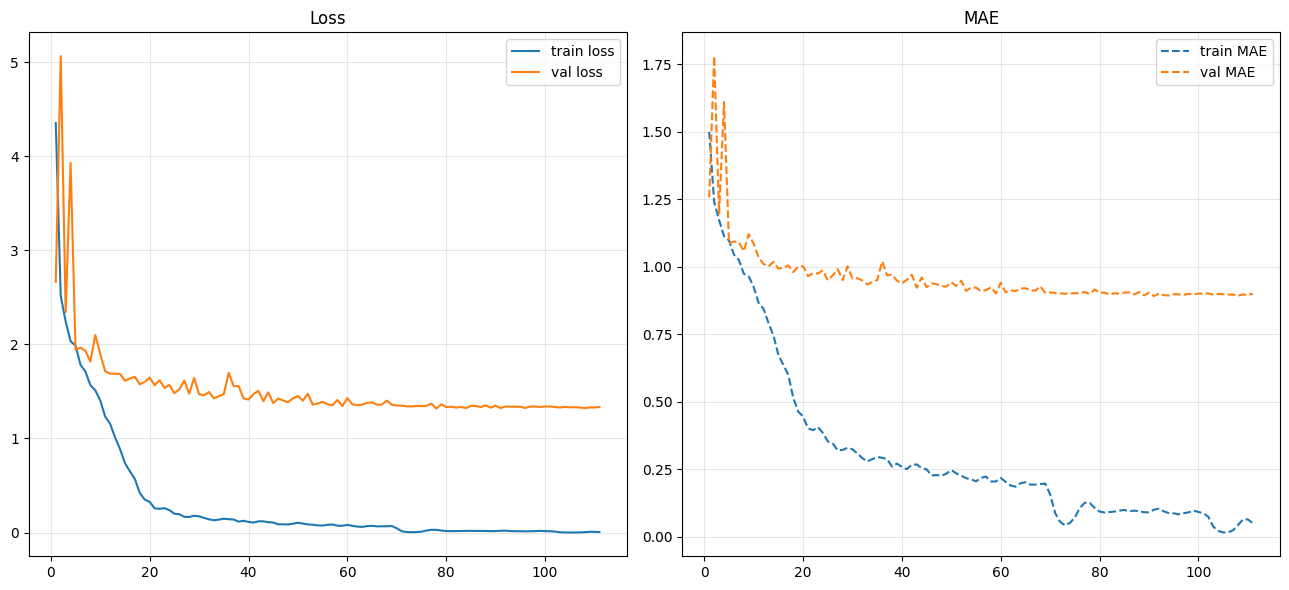

training:  74%|███████▍   111/150 [06:30<02:07] , loss=0.0046, mse=0.0046


Epoch 111: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 111: early stopping
Restoring model weights from the end of the best epoch: 91.


[2.6648614406585693, 5.063845634460449, 2.344569206237793, 3.929729700088501, 1.9453811645507812, 1.9645658731460571, 1.9303885698318481, 1.8176279067993164, 2.0987908840179443, 1.8983262777328491, 1.7136114835739136, 1.6887049674987793, 1.6878122091293335, 1.6858195066452026, 1.6129732131958008, 1.637225866317749, 1.6544467210769653, 1.575881838798523, 1.6002488136291504, 1.6479507684707642, 1.5664849281311035, 1.617983341217041, 1.537594199180603, 1.5686765909194946, 1.4805341958999634, 1.5220626592636108, 1.6145977973937988, 1.4756158590316772, 1.6436253786087036, 1.4692691564559937, 1.4592649936676025, 1.4936423301696777, 1.4258477687835693, 1.44949471950531, 1.469883680343628, 1.6988356113433838, 1.5551377534866333, 1.5583235025405884, 1.425309658050537, 1.4135558605194092, 1.4722322225570679, 1.5052682161331177, 1.395616888999939, 1.4896724224090576, 1.3754743337631226, 1.424599051475525, 1.4027642011642456, 1.3852258920669556, 1.426003336906433, 1.4516807794570923, 1.40079104900

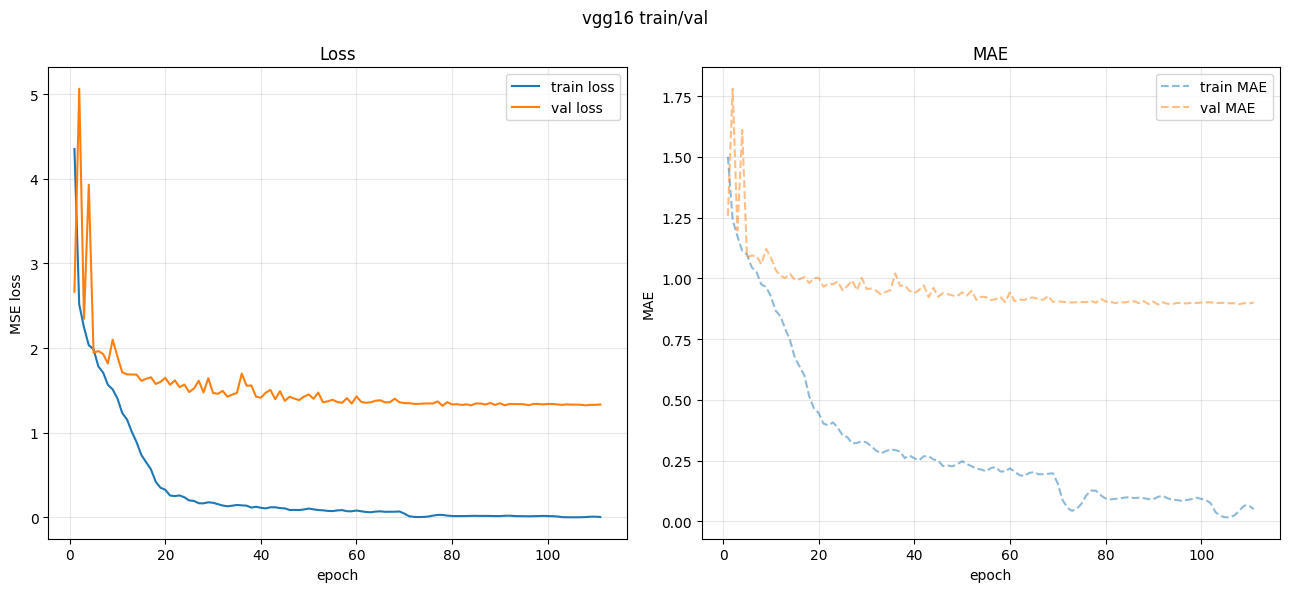

In [ ]:
vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16"
)

## Effect of Batch Norm

Batch norm may help increase gradient flows and because we are using minibatch it acts as a regularizer as each batch has different mean and std.

The problem arises when where to put batchnorm. Before reLU or after relu

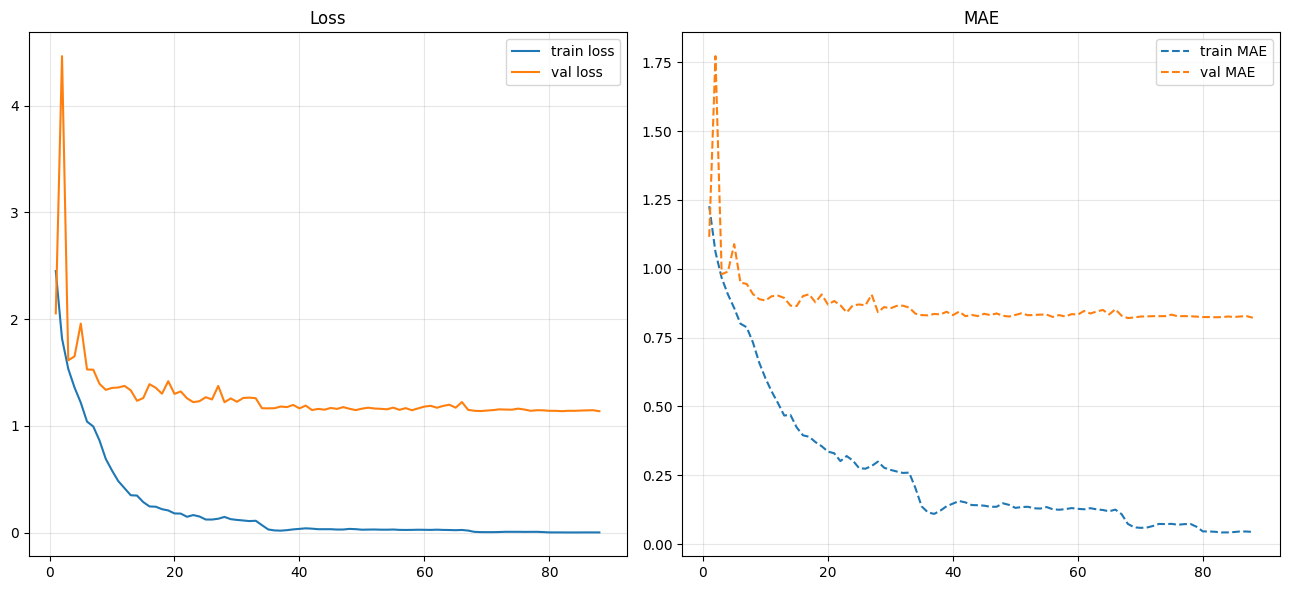

training:  59%|█████▊     88/150 [05:47<03:47] , loss=0.0033, mse=0.0033


Epoch 88: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


Epoch 88: early stopping
Restoring model weights from the end of the best epoch: 68.


[2.054931640625, 4.463595867156982, 1.6153348684310913, 1.6515079736709595, 1.9586849212646484, 1.5296648740768433, 1.5270931720733643, 1.394717812538147, 1.3387395143508911, 1.3564664125442505, 1.360583782196045, 1.3754603862762451, 1.3339749574661255, 1.2360961437225342, 1.2617520093917847, 1.3914984464645386, 1.357940673828125, 1.3024723529815674, 1.41965651512146, 1.300774335861206, 1.3237882852554321, 1.259537696838379, 1.2233856916427612, 1.2321672439575195, 1.2696473598480225, 1.2486851215362549, 1.3751797676086426, 1.2224642038345337, 1.2584481239318848, 1.2267941236495972, 1.2626183032989502, 1.2657451629638672, 1.2602035999298096, 1.1664061546325684, 1.1653118133544922, 1.1665196418762207, 1.1820956468582153, 1.1769911050796509, 1.1970772743225098, 1.1651077270507812, 1.1911091804504395, 1.149305820465088, 1.1601234674453735, 1.1528444290161133, 1.1688733100891113, 1.1602641344070435, 1.176764726638794, 1.1613515615463257, 1.149096131324768, 1.1622107028961182, 1.171521782875

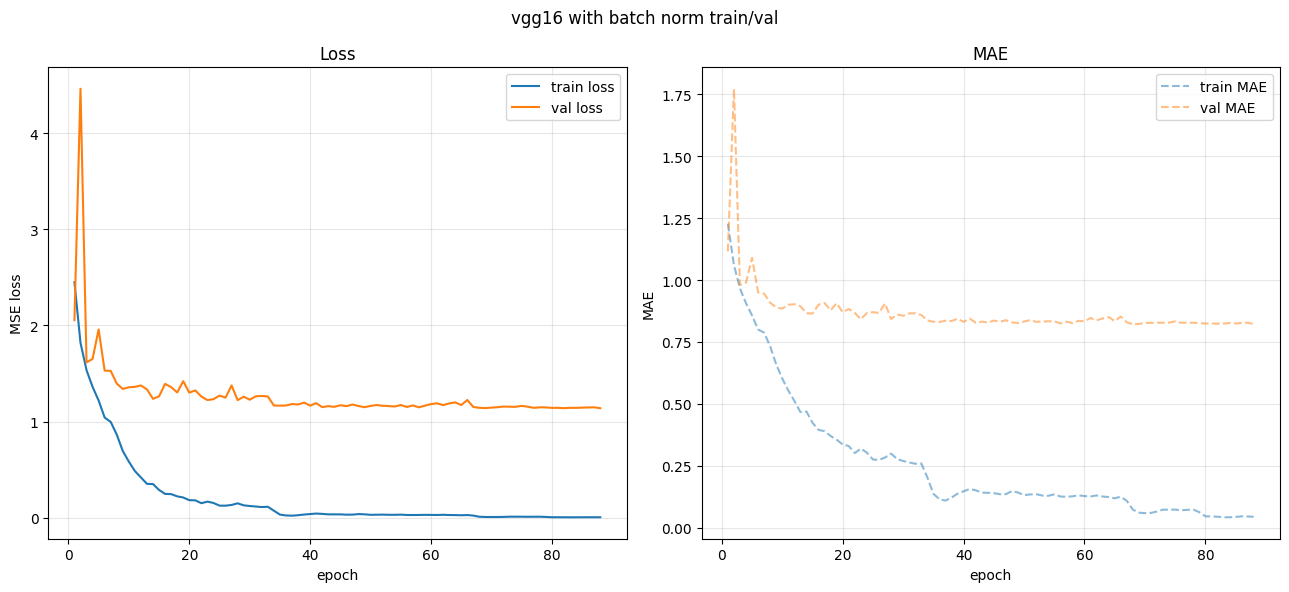

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]
vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg16_dilated_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3 (dilated; no pool)
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},

    # Block 4 (stronger dilation; no pool)
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"batchnorm"},{"type":"activation","name":"relu"},
    {"type": "last_layer", "head_type": "fully_convolutional"}
]
vgg_dilated_layers_config = {
    "layers": vgg16_dilated_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm"
)


### After reLU

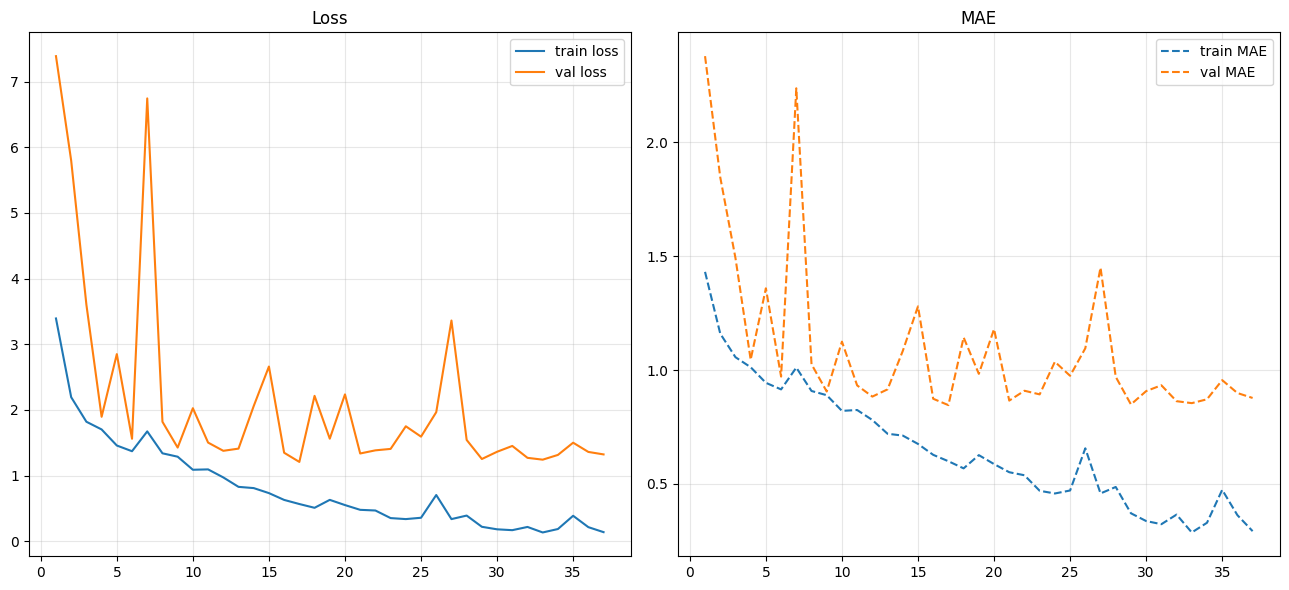

training:  74%|███████▍   37/50 [02:38<00:44] , loss=0.1391, mse=0.1391


Epoch 37: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 37: early stopping
Restoring model weights from the end of the best epoch: 17.


[7.386844158172607, 5.795535564422607, 3.60244083404541, 1.8953381776809692, 2.84991192817688, 1.5611140727996826, 6.743474006652832, 1.8197144269943237, 1.426793098449707, 2.026277780532837, 1.5027945041656494, 1.3775614500045776, 1.4109110832214355, 2.059098243713379, 2.6607396602630615, 1.348149061203003, 1.2084532976150513, 2.2143161296844482, 1.5622634887695312, 2.2366020679473877, 1.3368923664093018, 1.384722113609314, 1.4065752029418945, 1.7510446310043335, 1.593342900276184, 1.965905785560608, 3.36129093170166, 1.543092131614685, 1.2528903484344482, 1.3630210161209106, 1.4516777992248535, 1.2705254554748535, 1.2426667213439941, 1.315071702003479, 1.5011088848114014, 1.3604652881622314, 1.3227473497390747]
{'loss': 0.13912928104400635, 'val_loss': 1.3227473497390747, 'mean_absolute_error': 0.292164146900177, 'val_mean_absolute_error': 0.877171516418457}
[vgg16_dilated (batch norm After ReLU added)] last: loss=0.1391 | val_loss=1.3227 | rMAE=0.2922 | val_rMAE=0.8772


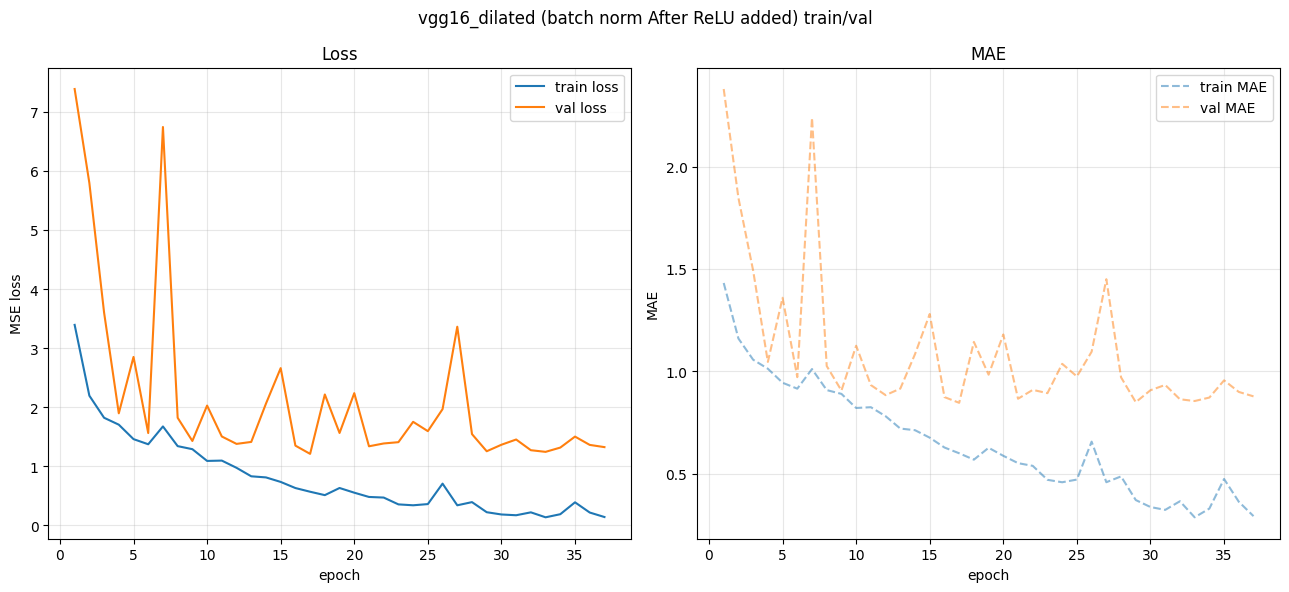

In [ ]:
vgg16_dilated_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3 (dilated; no pool)
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":2,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},

    # Block 4 (stronger dilation; no pool)
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","dilation":4,"initialization":"he_normal"},
    {"type":"activation","name":"relu"}, {"type":"batchnorm"},
    {"type": "last_layer", "head_type": "fully_convolutional"}
]
vgg_dilated_layers_config = {
    "layers": vgg16_dilated_layers,
    "computation_sequence": "sequential"
}
vgg_dilated = AttractRegressorModel(vgg_dilated_layers_config)
hist_dil = train_with_val(
    vgg_dilated, train_dataset, validation_dataset,
    epochs=50, batch_size=32, lr=3e-4, name="vgg16_dilated (batch norm After ReLU added)"
)


**Result**: Interestingly somehow, batchnorm doesn't have much impact. Especially batchnorm after ReLU performed worse.
Before ReLU batchnorm made the model instable. It maybe either because of the affect of Dilated convolutions in further layer or somelayers are not required to be normalized at all. Therefore, I will try strong regularizers like L2 Norm and weight decay.

## Effect of dropout


### Dropout without batch normalization

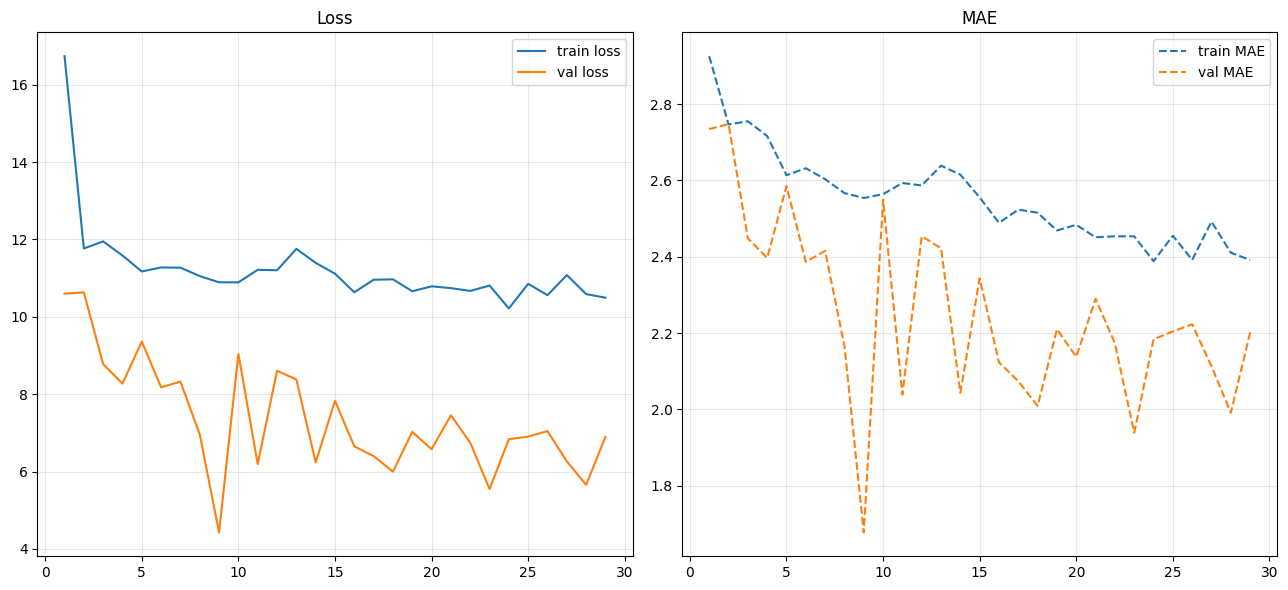

training:  19%|█▉         29/150 [01:58<06:50] , loss=10.4933, mse=10.4933


Epoch 29: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.


[10.596794128417969, 10.63122272491455, 8.774259567260742, 8.273911476135254, 9.359293937683105, 8.176379203796387, 8.3241605758667, 6.958995342254639, 4.42435884475708, 9.039491653442383, 6.191671848297119, 8.603719711303711, 8.379851341247559, 6.236473083496094, 7.82671594619751, 6.650085926055908, 6.398596286773682, 5.996842861175537, 7.024033546447754, 6.576087474822998, 7.453526020050049, 6.743875503540039, 5.546144008636475, 6.836334705352783, 6.901701927185059, 7.045650959014893, 6.261931896209717, 5.656303405761719, 6.895717144012451]
{'loss': 10.49326229095459, 'val_loss': 6.895717144012451, 'mean_absolute_error': 2.391447067260742, 'val_mean_absolute_error': 2.201995372772217}
[vgg16 with dropout, lower rate (no batch)] last: loss=10.4933 | val_loss=6.8957 | rMAE=2.3914 | val_rMAE=2.2020


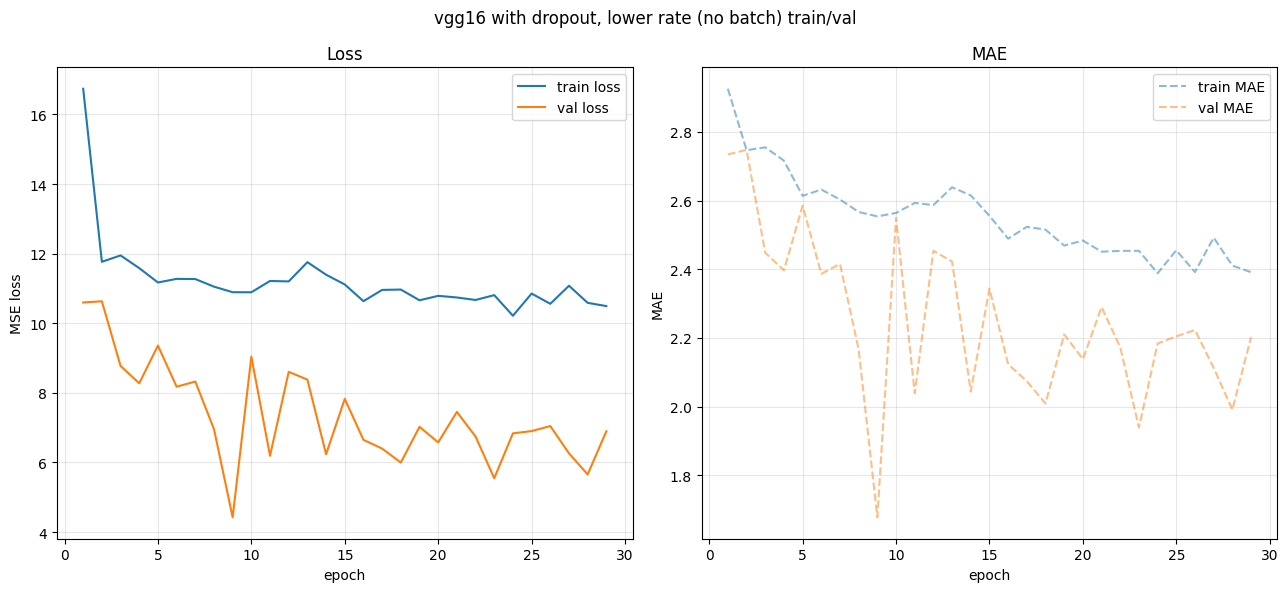

In [ ]:
# Investigating dropout: First, dropout layers without batchnorm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with fully_convolutional
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type": "dropout", "rate": 0.5}
     #
]
vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout, lower rate (no batch)"
)



### Dropout with batch normalization

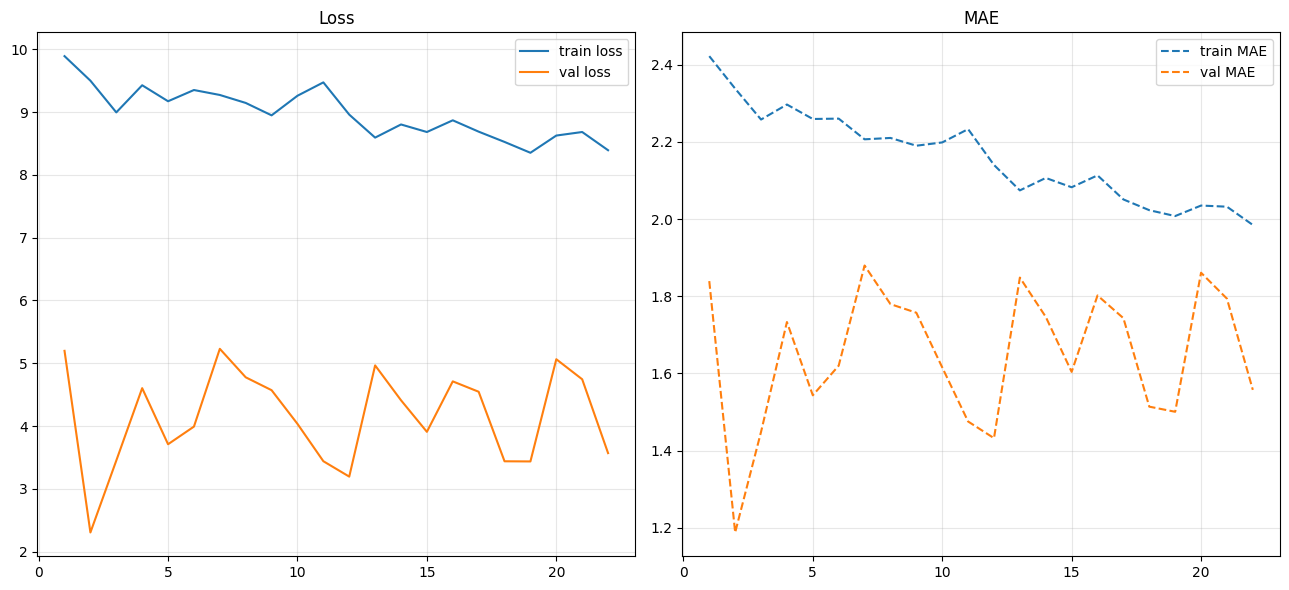

training:  15%|█▍         22/150 [01:53<08:14] , loss=8.3921, mse=8.3921


Epoch 22: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 2.


[5.198485374450684, 2.3072991371154785, 3.4518392086029053, 4.604503631591797, 3.711683511734009, 3.992621421813965, 5.230654239654541, 4.777340412139893, 4.572226047515869, 4.035909175872803, 3.4414615631103516, 3.196366548538208, 4.966724872589111, 4.411952018737793, 3.9093120098114014, 4.712398052215576, 4.547358989715576, 3.4403367042541504, 3.4379067420959473, 5.064885139465332, 4.7457098960876465, 3.5703892707824707]
{'loss': 8.392080307006836, 'val_loss': 3.5703892707824707, 'mean_absolute_error': 1.9847158193588257, 'val_mean_absolute_error': 1.5574398040771484}
[vgg16 with dropout and batch, lower rate] last: loss=8.3921 | val_loss=3.5704 | rMAE=1.9847 | val_rMAE=1.5574


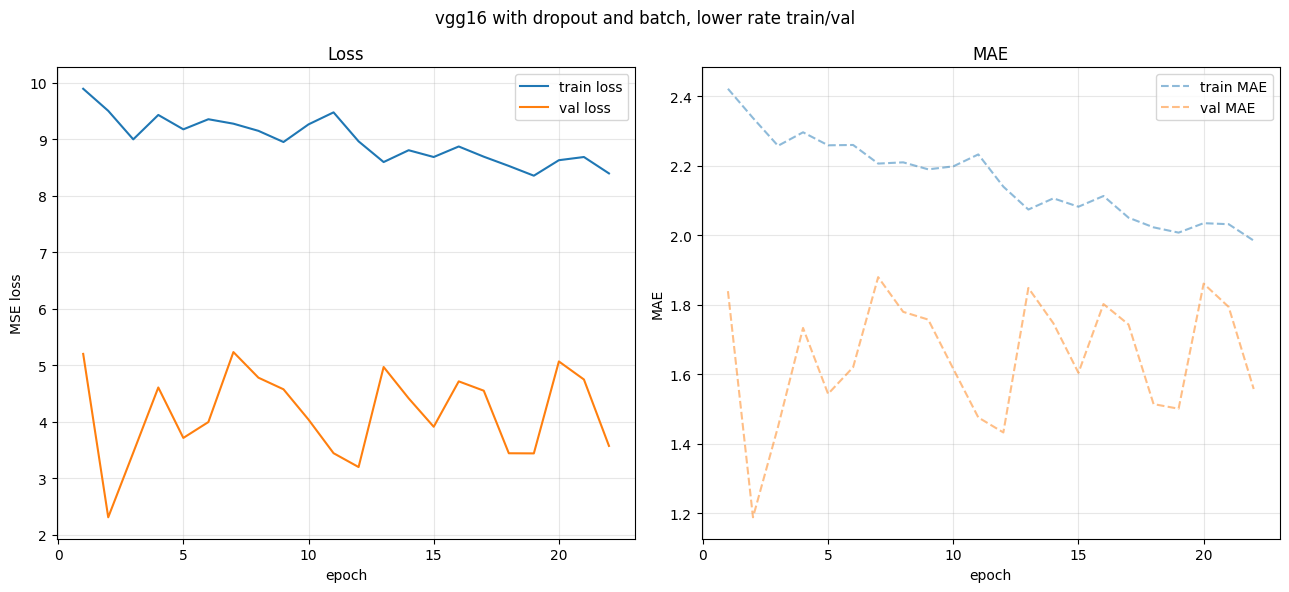

In [ ]:
# Investigating dropout: Then, dropout layers with batchnorm
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 5 / MLP Head
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type":"dropout","rate":0.4}
]

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout and batch, lower rate"
)


### Dropout only at the dense layer, without batch normalization

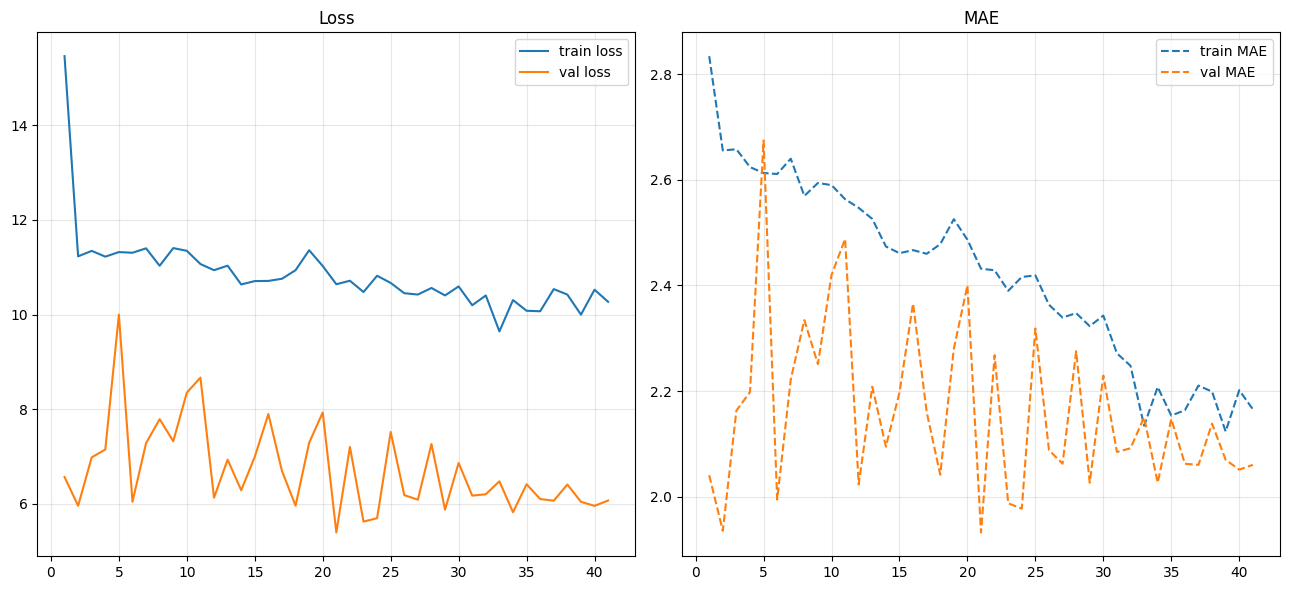

training:  27%|██▋        41/150 [02:32<06:12] , loss=10.2689, mse=10.2689


Epoch 41: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 21.


[6.566437244415283, 5.957661151885986, 6.981075763702393, 7.147704601287842, 9.998234748840332, 6.043057441711426, 7.282309532165527, 7.788604259490967, 7.321121692657471, 8.348858833312988, 8.66677474975586, 6.127871513366699, 6.933138370513916, 6.285749435424805, 6.994335174560547, 7.89684534072876, 6.692270755767822, 5.960525989532471, 7.289988994598389, 7.931670665740967, 5.393512725830078, 7.20191764831543, 5.6233415603637695, 5.694739818572998, 7.51747465133667, 6.183026313781738, 6.086504936218262, 7.26312255859375, 5.876162052154541, 6.862245559692383, 6.171969413757324, 6.201156139373779, 6.474940299987793, 5.821813583374023, 6.412128448486328, 6.099945068359375, 6.065283298492432, 6.4067769050598145, 6.041858196258545, 5.955382347106934, 6.0692458152771]
{'loss': 10.268864631652832, 'val_loss': 6.0692458152771, 'mean_absolute_error': 2.165666103363037, 'val_mean_absolute_error': 2.0602903366088867}
[vgg16 with dropout only at last layer (no batch)] last: loss=10.2689 | val_lo

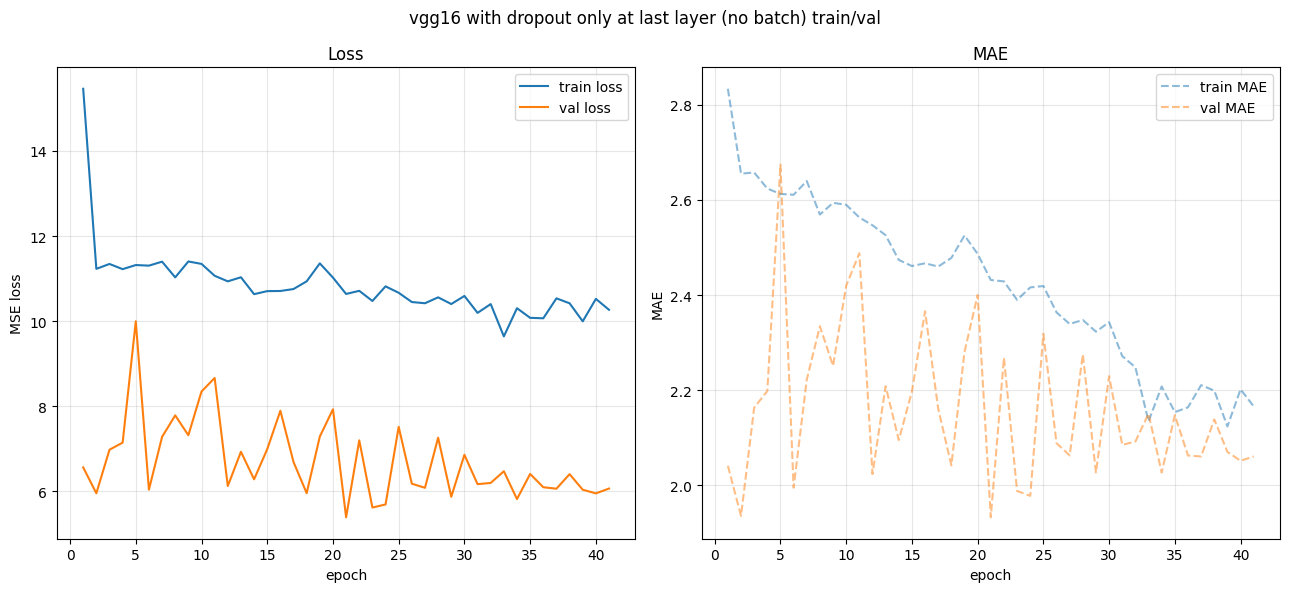

In [ ]:
# Investigating dropout: Dropout only at the last layer
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type": "dropout", "rate": 0.5}
     #
]
vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout only at last layer (no batch)"
)




### Dropout only at the dense layer, with batch normalization


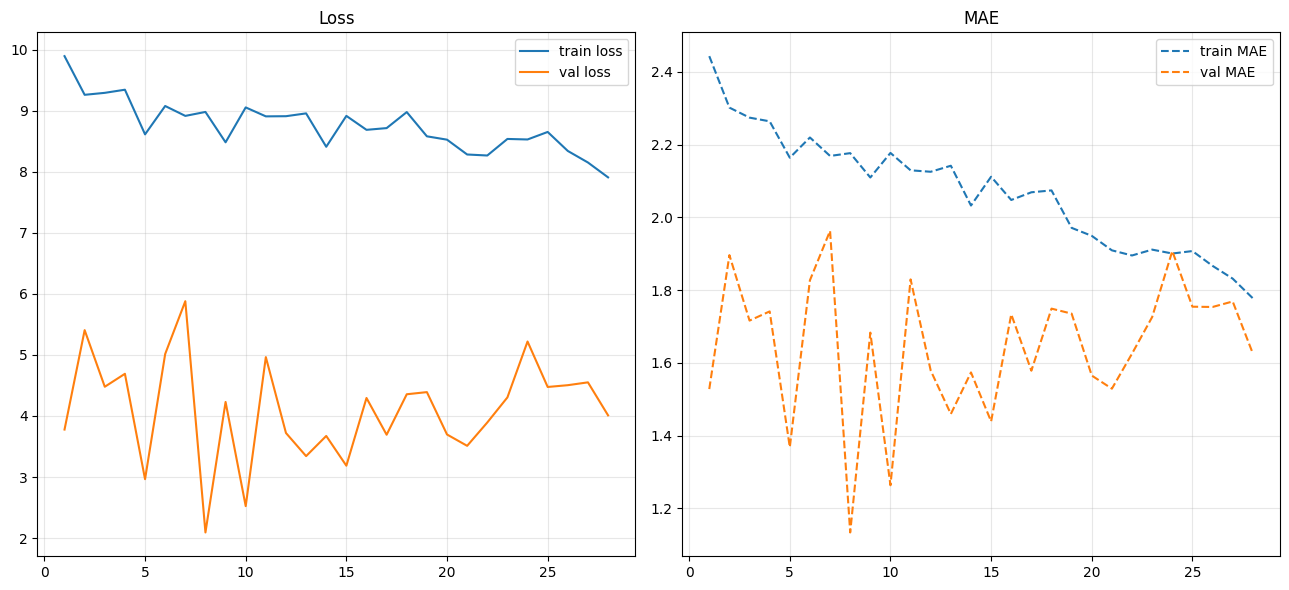

training:  19%|█▊         28/150 [02:09<07:41] , loss=7.9110, mse=7.9110


Epoch 28: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 8.


[3.777623176574707, 5.40698766708374, 4.479097366333008, 4.691582679748535, 2.9642302989959717, 5.01606559753418, 5.881511688232422, 2.091075897216797, 4.230422496795654, 2.522810220718384, 4.965189456939697, 3.721221923828125, 3.3424198627471924, 3.6727468967437744, 3.1852540969848633, 4.295029640197754, 3.6929032802581787, 4.356165885925293, 4.391247749328613, 3.69679594039917, 3.510921001434326, 3.893634796142578, 4.304720878601074, 5.220656871795654, 4.475614547729492, 4.504859924316406, 4.551368713378906, 4.010484218597412]
{'loss': 7.911032676696777, 'val_loss': 4.010484218597412, 'mean_absolute_error': 1.7774219512939453, 'val_mean_absolute_error': 1.6257777214050293}
[vgg16 with dropout and batch, only at the last layer] last: loss=7.9110 | val_loss=4.0105 | rMAE=1.7774 | val_rMAE=1.6258


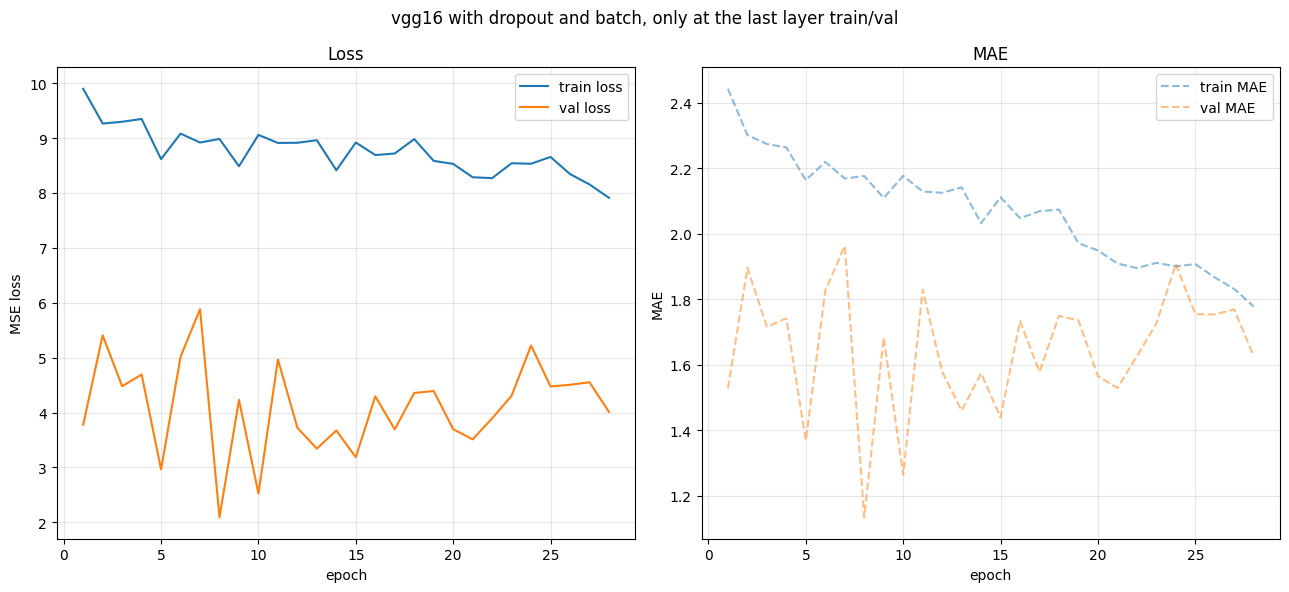

In [ ]:
# Dropout only at the last layer, with batch norm

vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 5 / MLP Head
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type":"dropout","rate":0.4}
]

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout and batch, only at the last layer"
)



## Effect of L2 Regularization



### Set L2 rate here

In [ ]:
l2_rate = 1e-4

### Initial model + L2



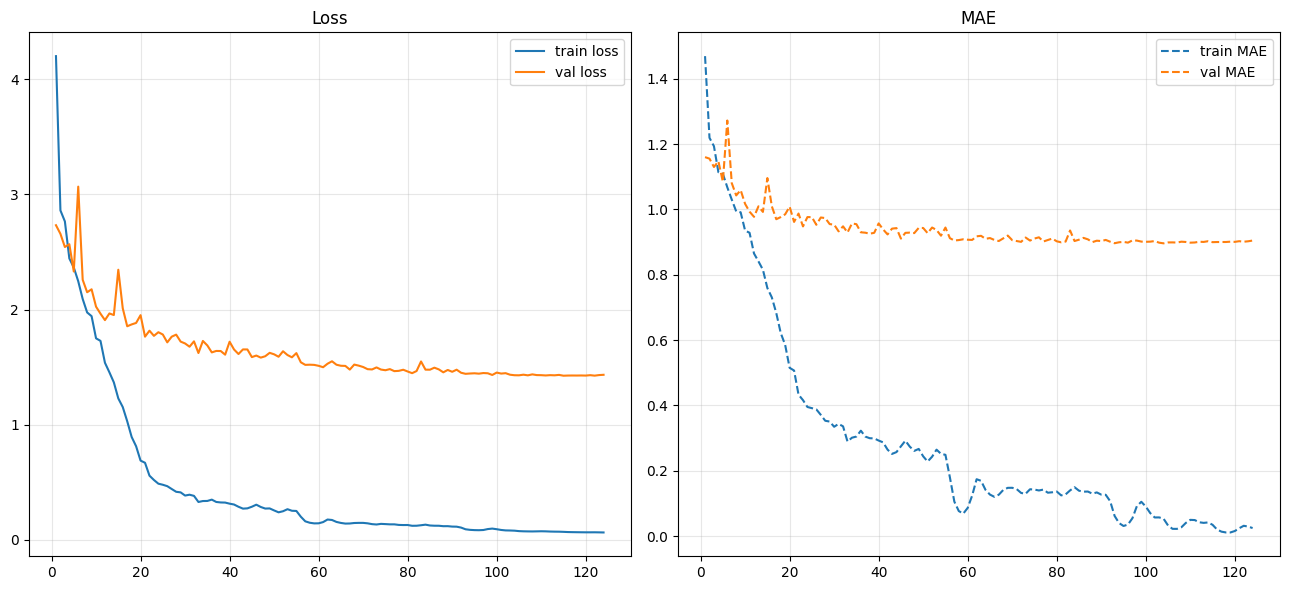

training:  83%|████████▎  124/150 [07:09<01:26] , loss=0.0646, mse=0.0011


Epoch 124: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 124: early stopping
Restoring model weights from the end of the best epoch: 104.


[2.732675075531006, 2.65792179107666, 2.543426990509033, 2.567608118057251, 2.3310396671295166, 3.067791223526001, 2.2590298652648926, 2.150526523590088, 2.1762402057647705, 2.0254876613616943, 1.9644521474838257, 1.908650279045105, 1.9665381908416748, 1.9527242183685303, 2.346106767654419, 2.0113797187805176, 1.8552610874176025, 1.8713090419769287, 1.8840769529342651, 1.9516183137893677, 1.7648978233337402, 1.8168061971664429, 1.7720528841018677, 1.8035831451416016, 1.7834893465042114, 1.7154570817947388, 1.7649929523468018, 1.78261399269104, 1.7221564054489136, 1.705854892730713, 1.677861213684082, 1.7242382764816284, 1.622849941253662, 1.7276638746261597, 1.688673496246338, 1.6283111572265625, 1.6408648490905762, 1.640216588973999, 1.6086246967315674, 1.7209417819976807, 1.6534124612808228, 1.6141700744628906, 1.6541990041732788, 1.6537450551986694, 1.587491512298584, 1.6008564233779907, 1.5830246210098267, 1.5948150157928467, 1.624497652053833, 1.6116348505020142, 1.590489745140075

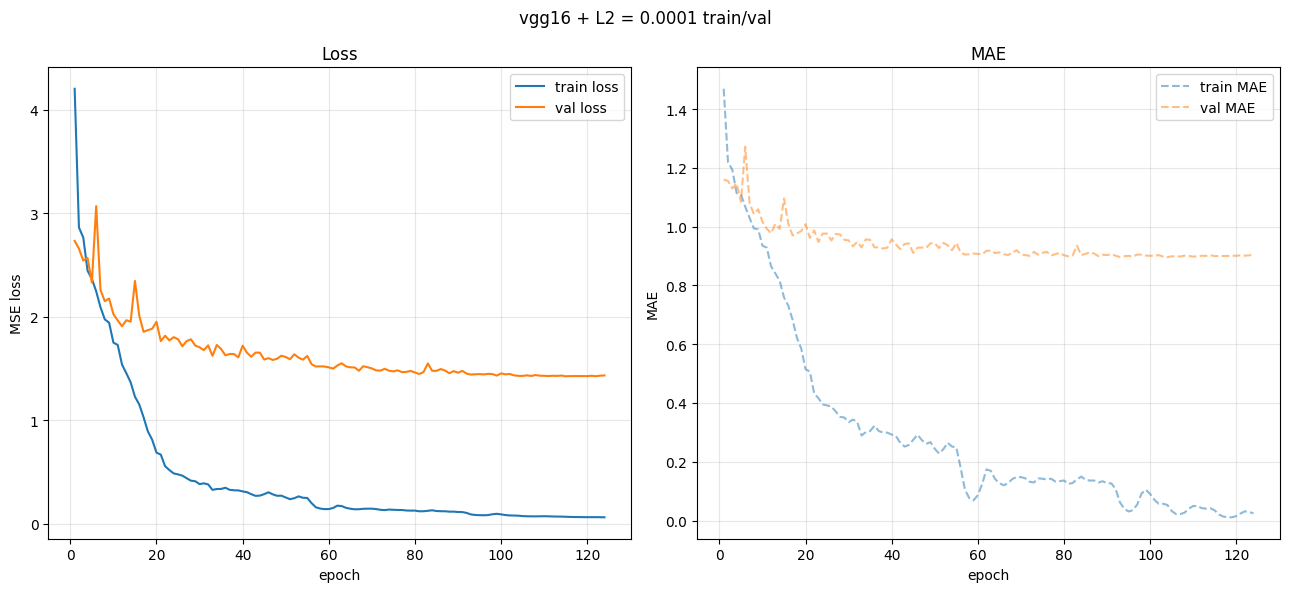

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 + L2 = " + str(l2_rate)
)

### Batch norm + L2

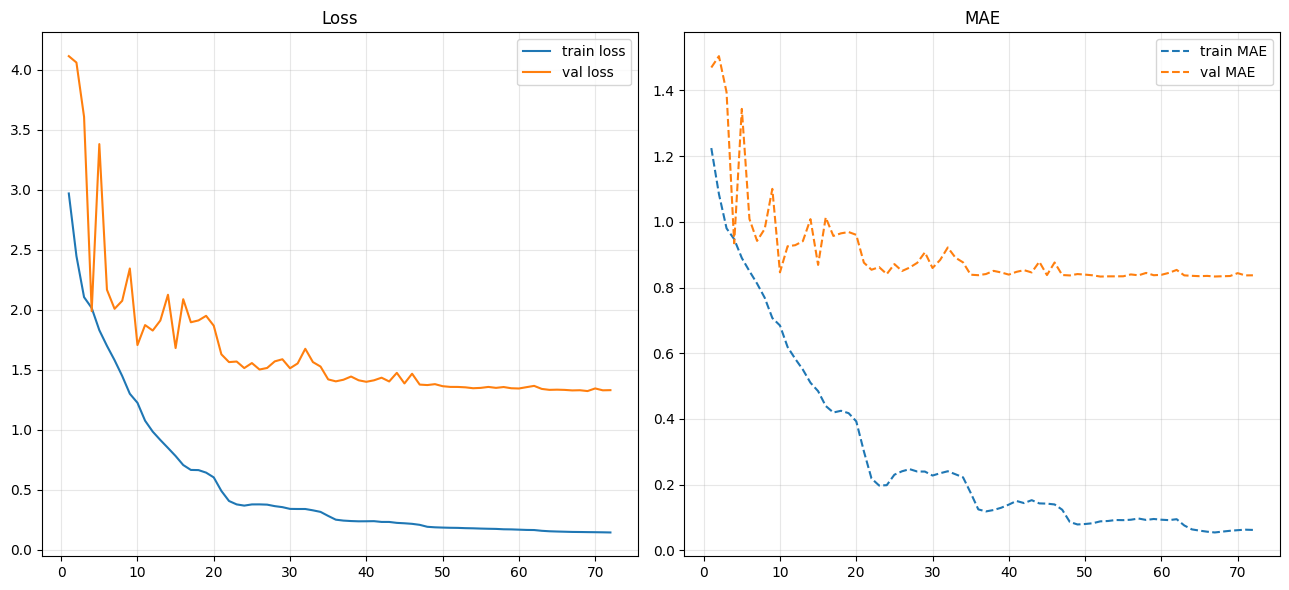

training:  48%|████▊      72/150 [04:51<04:53] , loss=0.1441, mse=0.0066


Epoch 72: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 72: early stopping
Restoring model weights from the end of the best epoch: 52.


[4.115138530731201, 4.061831951141357, 3.60935640335083, 1.9889602661132812, 3.381906747817993, 2.167567729949951, 2.008575439453125, 2.0756232738494873, 2.3447141647338867, 1.7064118385314941, 1.873173713684082, 1.8275316953659058, 1.9111828804016113, 2.125863552093506, 1.681720495223999, 2.0887701511383057, 1.896555781364441, 1.911841869354248, 1.9500341415405273, 1.8677499294281006, 1.6292858123779297, 1.5643317699432373, 1.5691726207733154, 1.5146316289901733, 1.5564080476760864, 1.502519965171814, 1.5155764818191528, 1.5704693794250488, 1.5880913734436035, 1.5129506587982178, 1.5532891750335693, 1.6753144264221191, 1.5645287036895752, 1.5271763801574707, 1.4202766418457031, 1.4038729667663574, 1.417344093322754, 1.4441190958023071, 1.4126238822937012, 1.400189995765686, 1.4124737977981567, 1.4343669414520264, 1.4028961658477783, 1.474745273590088, 1.386475682258606, 1.4676086902618408, 1.3767982721328735, 1.3729722499847412, 1.3805011510849, 1.3635741472244263, 1.3576101064682007,

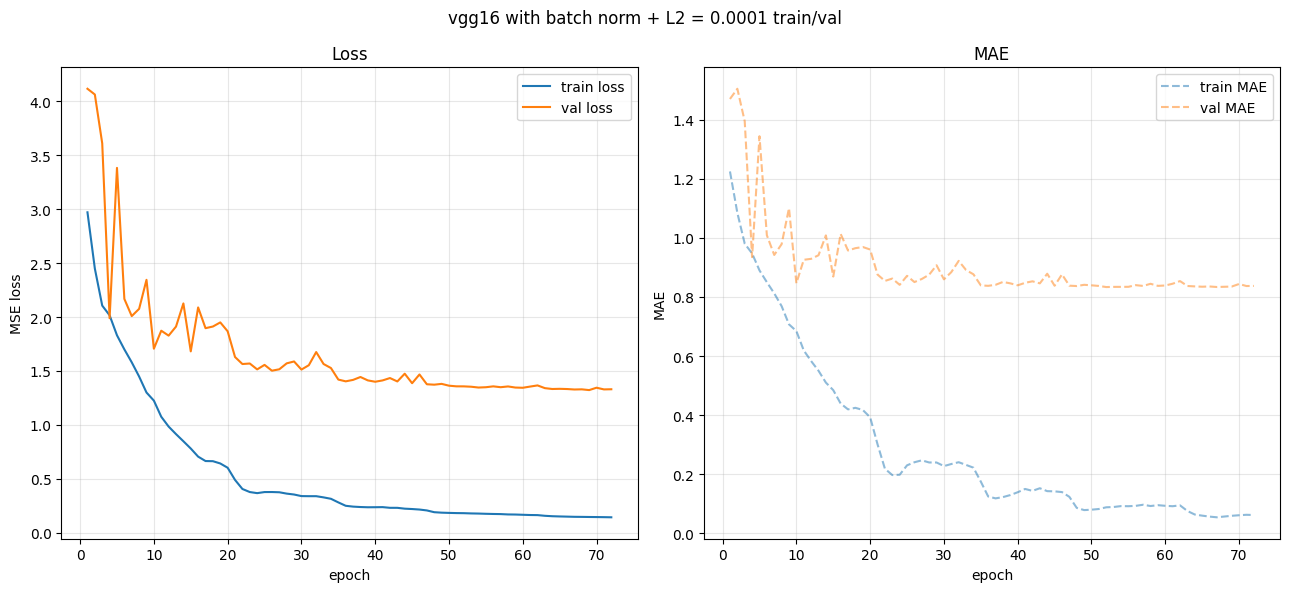

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

### Model with dropout + L2

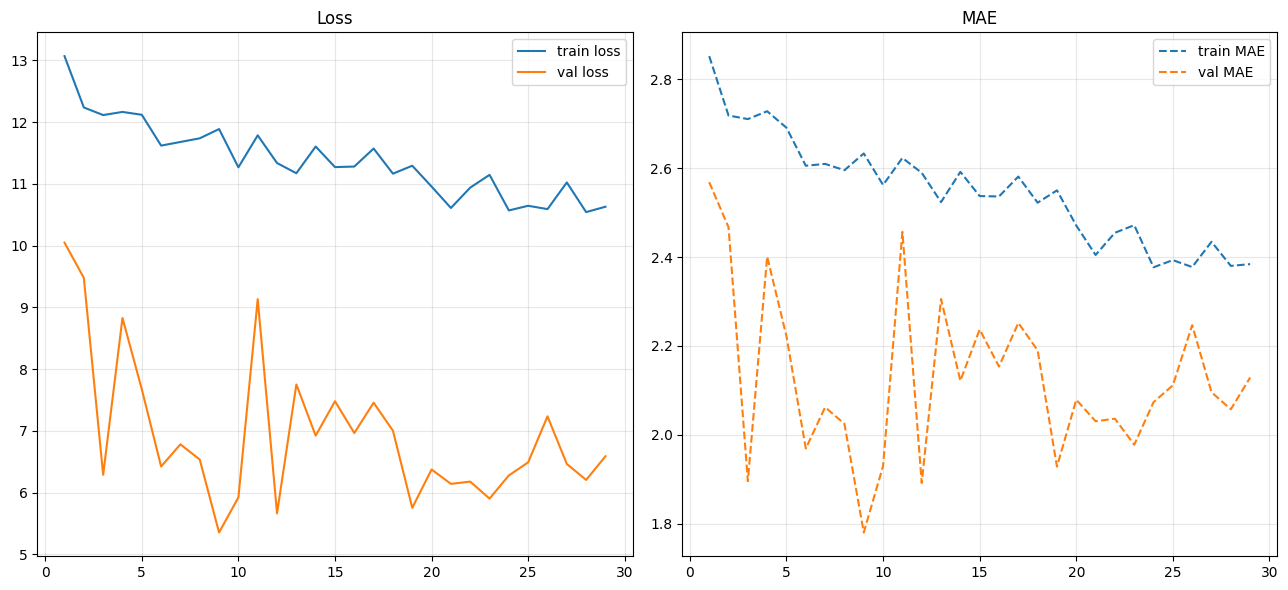

training:  19%|█▉         29/150 [01:58<06:53] , loss=10.6287, mse=10.4909


Epoch 29: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 29: early stopping
Restoring model weights from the end of the best epoch: 9.


[10.047338485717773, 9.476317405700684, 6.289248943328857, 8.828557014465332, 7.673701763153076, 6.423652172088623, 6.7825517654418945, 6.535721302032471, 5.355668544769287, 5.922361850738525, 9.132941246032715, 5.6648640632629395, 7.7513909339904785, 6.9227776527404785, 7.479991436004639, 6.965236186981201, 7.456363201141357, 7.002717971801758, 5.754640579223633, 6.375100135803223, 6.142665386199951, 6.179035663604736, 5.9035444259643555, 6.279168605804443, 6.491342544555664, 7.235638618469238, 6.464474678039551, 6.206125736236572, 6.5890045166015625]
{'loss': 10.628678321838379, 'val_loss': 6.5890045166015625, 'mean_absolute_error': 2.384219169616699, 'val_mean_absolute_error': 2.1287906169891357}
[vgg16 with dropout (no batch) + L2 = 0.0001] last: loss=10.6287 | val_loss=6.5890 | rMAE=2.3842 | val_rMAE=2.1288


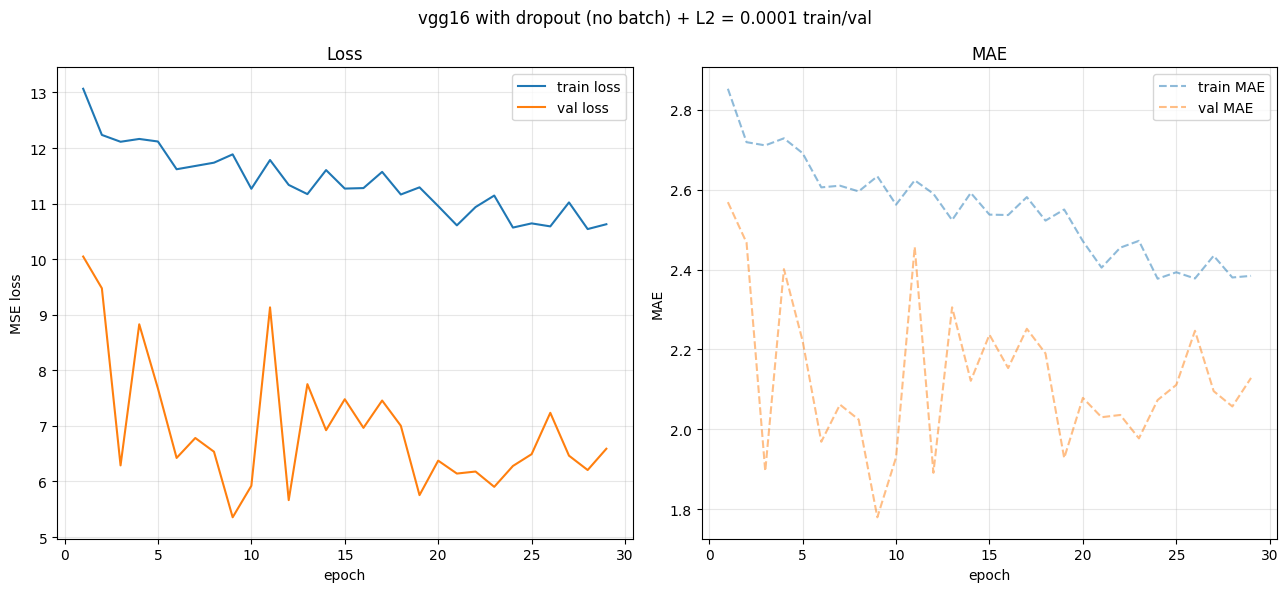

In [ ]:
# Investigating dropout: First, dropout layers without batchnorm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "he_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    {"type": "dropout", "rate": 0.1},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type": "dropout", "rate": 0.5}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}


vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout (no batch) + L2 = " + str(l2_rate)
)



### Model with dropout and batch normalization + L2

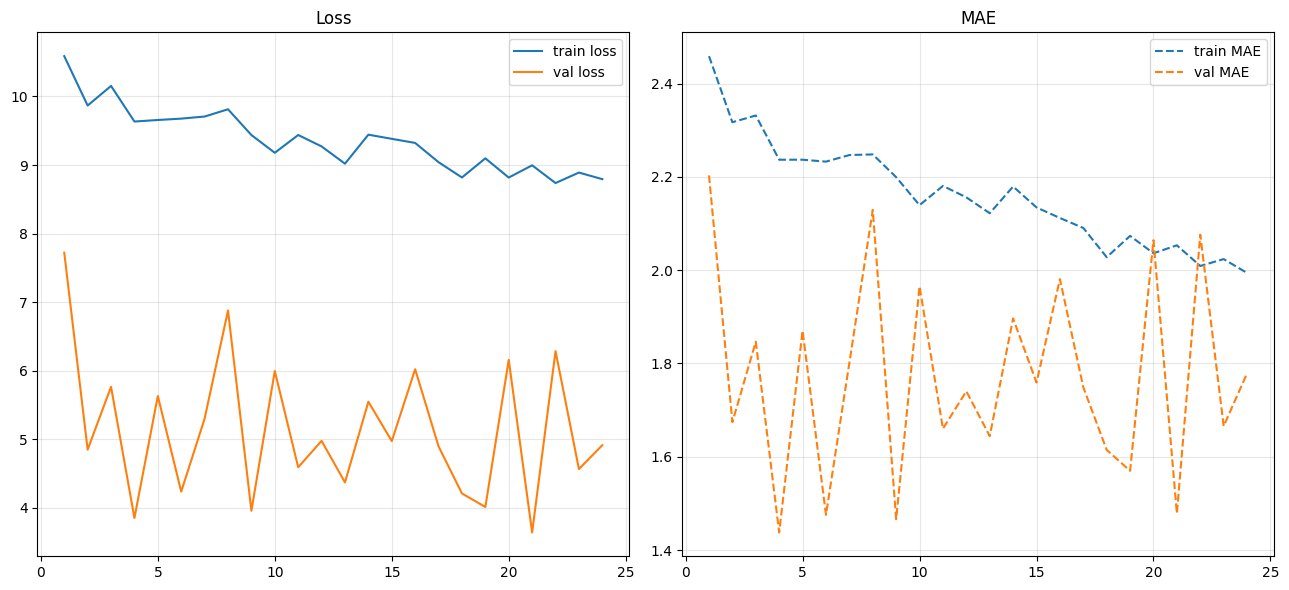

training:  16%|█▌         24/150 [02:01<08:11] , loss=8.7939, mse=8.4854


Epoch 24: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 24: early stopping
Restoring model weights from the end of the best epoch: 4.


[7.721451759338379, 4.8476481437683105, 5.764030933380127, 3.850111484527588, 5.629714488983154, 4.234499454498291, 5.3000807762146, 6.877224922180176, 3.9553186893463135, 5.994523525238037, 4.590359687805176, 4.975547790527344, 4.3692426681518555, 5.546815395355225, 4.972110748291016, 6.020352363586426, 4.894915580749512, 4.208131313323975, 4.010373592376709, 6.156656265258789, 3.6389102935791016, 6.2850518226623535, 4.564452171325684, 4.912500858306885]
{'loss': 8.793940544128418, 'val_loss': 4.912500858306885, 'mean_absolute_error': 1.9939969778060913, 'val_mean_absolute_error': 1.7787119150161743}
[vgg16 with dropout and batch + L2 = 0.0001] last: loss=8.7939 | val_loss=4.9125 | rMAE=1.9940 | val_rMAE=1.7787


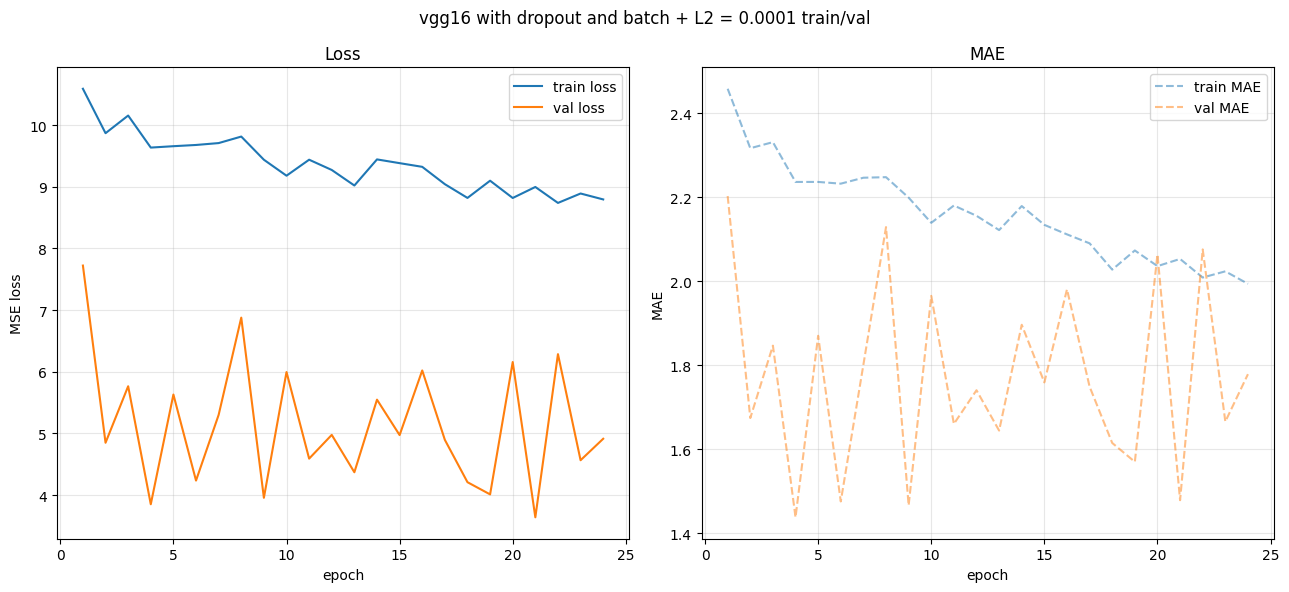

In [ ]:
# Investigating dropout: Then, dropout layers with batchnorm
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    {"type":"dropout","rate":0.1},

    # Block 5 / MLP Head
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type":"dropout","rate":0.4}
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout and batch + L2 = " + str(l2_rate)
)


### Dropout only at the dense layer, with batch normalization + L2

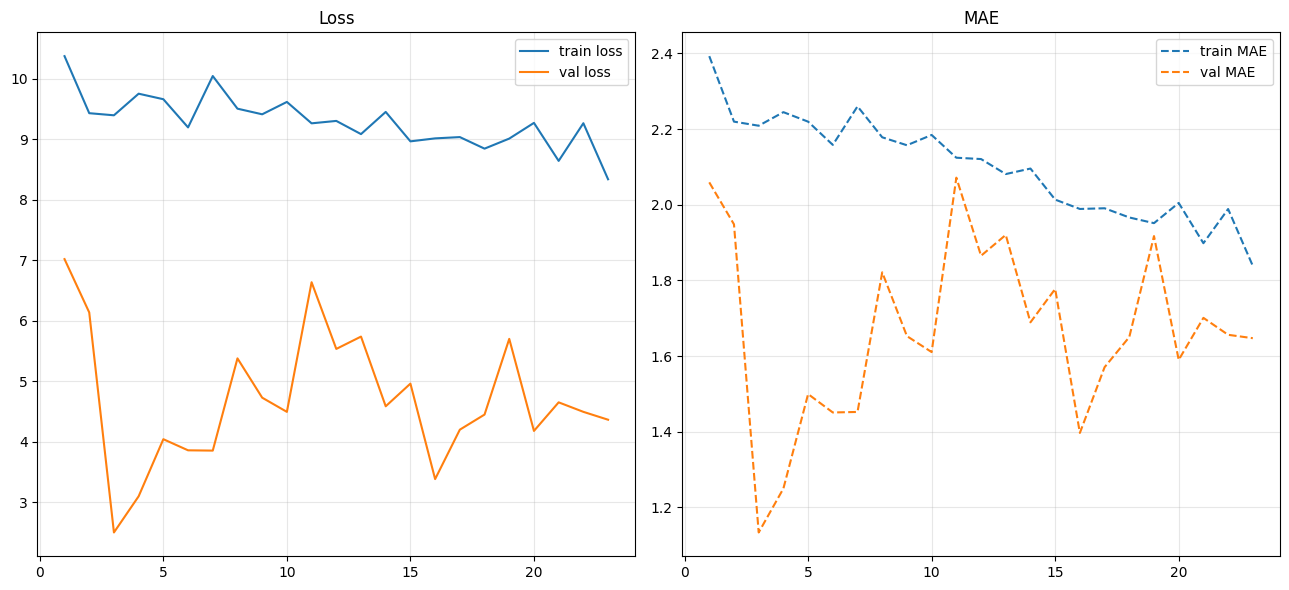

training:  15%|█▌         23/150 [01:51<08:08] , loss=8.3389, mse=7.9901


Epoch 23: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


Epoch 23: early stopping
Restoring model weights from the end of the best epoch: 3.


[7.01940393447876, 6.137795448303223, 2.5014231204986572, 3.0993971824645996, 4.042802810668945, 3.859102249145508, 3.8543126583099365, 5.378732681274414, 4.729250431060791, 4.494582176208496, 6.6371965408325195, 5.534968376159668, 5.738777160644531, 4.58687162399292, 4.961574077606201, 3.3836288452148438, 4.20018196105957, 4.449892520904541, 5.701116561889648, 4.179574966430664, 4.651996612548828, 4.494967460632324, 4.364737033843994]
{'loss': 8.33893871307373, 'val_loss': 4.364737033843994, 'mean_absolute_error': 1.8381121158599854, 'val_mean_absolute_error': 1.6471275091171265}
[vgg16 with dropout and batch, only at the last layer] last: loss=8.3389 | val_loss=4.3647 | rMAE=1.8381 | val_rMAE=1.6471


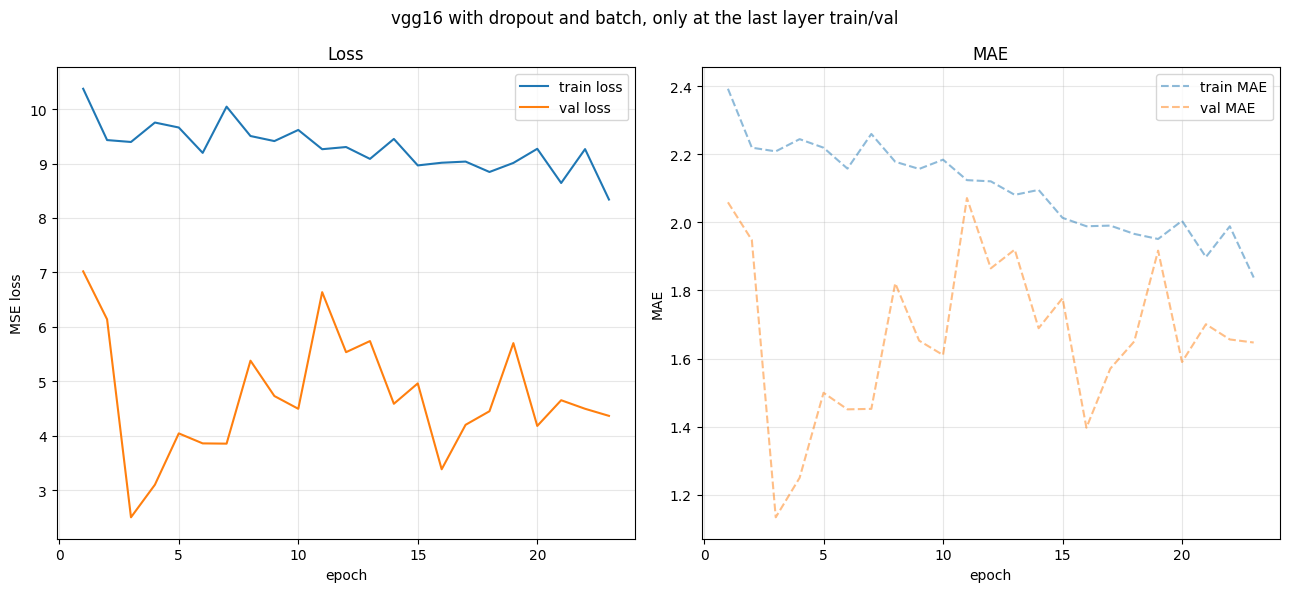

In [ ]:
# Dropout only at the last layer, with batch norm

vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"he_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 5 / MLP Head
    {"type": "last_layer", "head_type": "fully_convolutional"},
    {"type":"dropout","rate":0.4}
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with dropout and batch, only at the last layer"
)



# Investigation of Gaussian and Xavier and Xavier/2 initializations

## Initial model + L2 + random normal

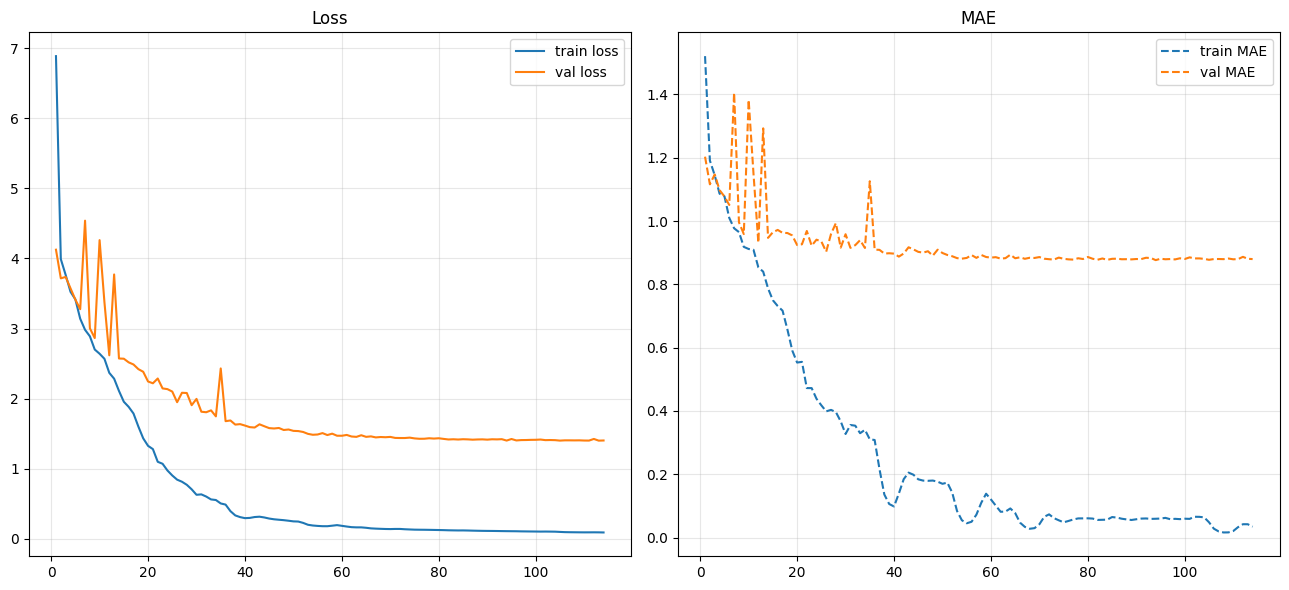

training:  76%|███████▌   114/150 [06:36<02:04] , loss=0.0906, mse=0.0020


Epoch 114: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 114: early stopping
Restoring model weights from the end of the best epoch: 94.


[4.125258445739746, 3.7167775630950928, 3.736980438232422, 3.5741798877716064, 3.413422107696533, 3.2767481803894043, 4.539617538452148, 3.003227710723877, 2.8645808696746826, 4.262109756469727, 3.376441717147827, 2.6185481548309326, 3.7721354961395264, 2.5730655193328857, 2.569896936416626, 2.51800537109375, 2.48734188079834, 2.421388864517212, 2.3835837841033936, 2.2448019981384277, 2.219301223754883, 2.287358283996582, 2.145984649658203, 2.135934352874756, 2.100801467895508, 1.9492874145507812, 2.0839431285858154, 2.0805110931396484, 1.9066050052642822, 1.9966753721237183, 1.813407301902771, 1.8061347007751465, 1.832982063293457, 1.7471997737884521, 2.431011199951172, 1.678746223449707, 1.6886564493179321, 1.6298409700393677, 1.6363788843154907, 1.6159883737564087, 1.5934767723083496, 1.5881625413894653, 1.6338592767715454, 1.60606050491333, 1.5795619487762451, 1.5743989944458008, 1.5813976526260376, 1.552801251411438, 1.559670329093933, 1.540307641029358, 1.5373033285140991, 1.5247

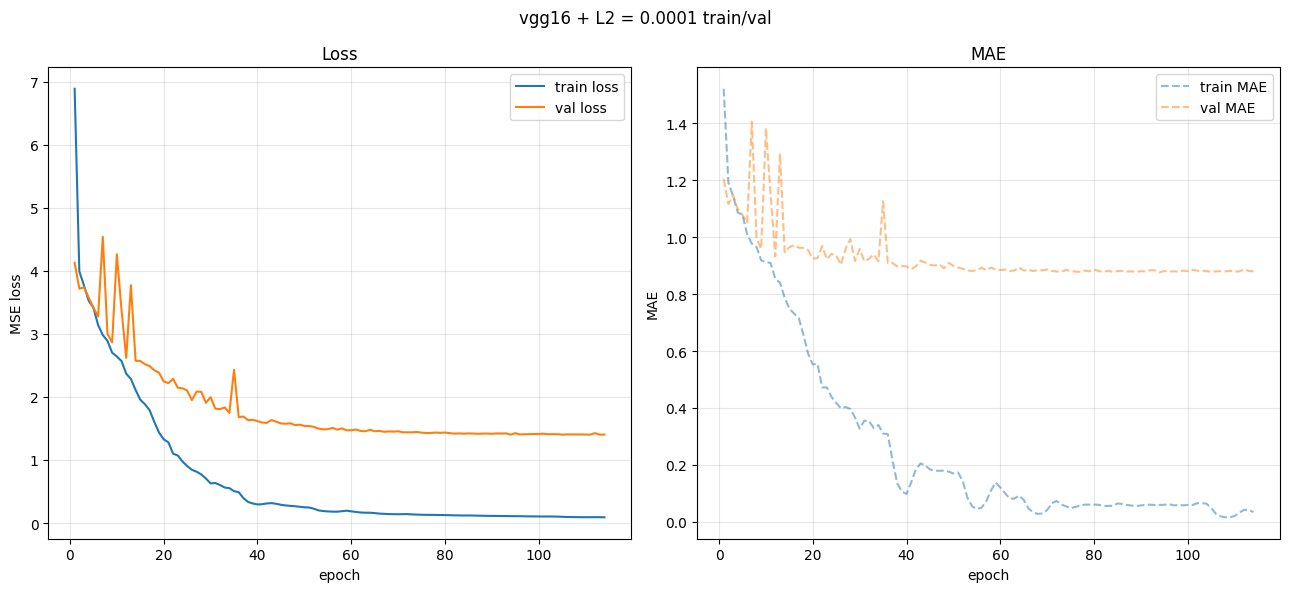

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "random_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 + L2 = " + str(l2_rate)
)

## Batch norm + L2 + random normal

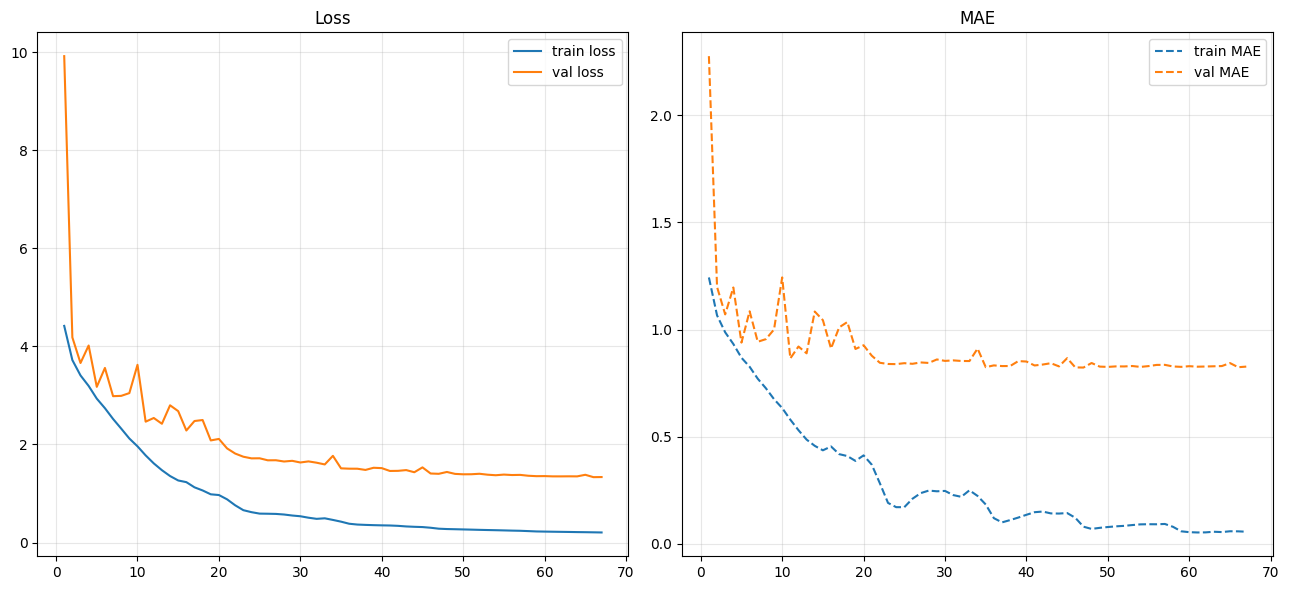

training:  45%|████▍      67/150 [04:33<05:10] , loss=0.2058, mse=0.0053


Epoch 67: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.


Epoch 67: early stopping
Restoring model weights from the end of the best epoch: 47.


[9.91683292388916, 4.18255615234375, 3.66084361076355, 4.01711368560791, 3.1746654510498047, 3.5602264404296875, 2.984502077102661, 2.9906868934631348, 3.047123432159424, 3.6238183975219727, 2.464653253555298, 2.5396666526794434, 2.4215314388275146, 2.7984960079193115, 2.679154396057129, 2.284594774246216, 2.477863073348999, 2.49806547164917, 2.0821871757507324, 2.1124868392944336, 1.919768214225769, 1.814439296722412, 1.7500393390655518, 1.716569185256958, 1.7180449962615967, 1.676802396774292, 1.6779922246932983, 1.6524286270141602, 1.666291356086731, 1.6323798894882202, 1.6546326875686646, 1.6279505491256714, 1.5926077365875244, 1.7679983377456665, 1.5128753185272217, 1.506195068359375, 1.5054364204406738, 1.4807919263839722, 1.5247082710266113, 1.517446756362915, 1.4596670866012573, 1.4620767831802368, 1.4773101806640625, 1.4337592124938965, 1.5325621366500854, 1.407831072807312, 1.401552677154541, 1.4392024278640747, 1.4000588655471802, 1.3916021585464478, 1.392703890800476, 1.402

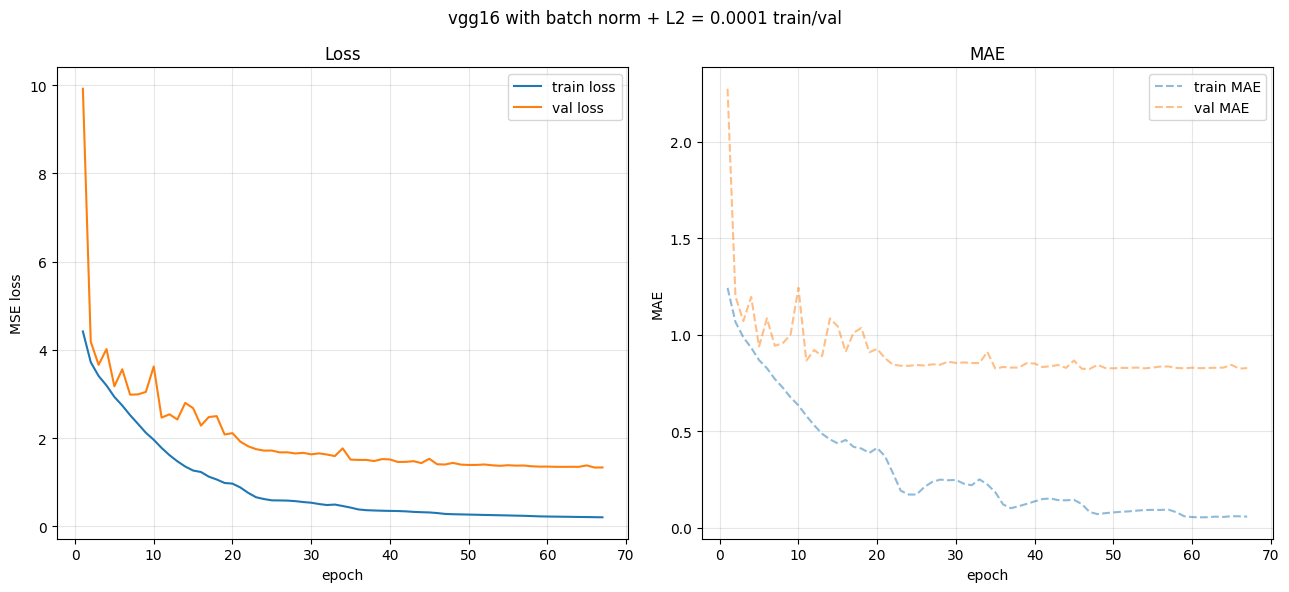

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"random_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

## Initial model + L2 + Xavier

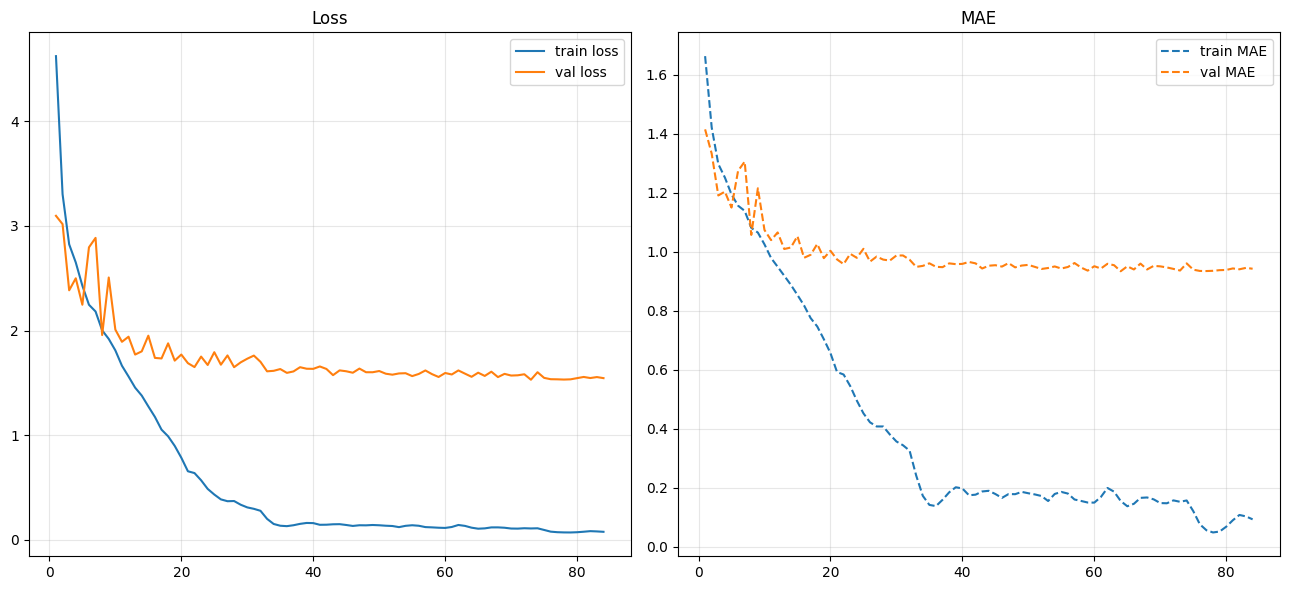

training:  56%|█████▌     84/150 [04:55<03:39] , loss=0.0749, mse=0.0143


Epoch 84: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 84: early stopping
Restoring model weights from the end of the best epoch: 64.


[3.0968801975250244, 3.017320394515991, 2.38454270362854, 2.499382734298706, 2.246431827545166, 2.7954704761505127, 2.8858742713928223, 1.9566806554794312, 2.5069289207458496, 2.008775472640991, 1.891966700553894, 1.9407365322113037, 1.7700423002243042, 1.8005353212356567, 1.9505963325500488, 1.7379627227783203, 1.7328438758850098, 1.8773499727249146, 1.7120417356491089, 1.770166039466858, 1.6877694129943848, 1.6503605842590332, 1.7506029605865479, 1.670251727104187, 1.7925385236740112, 1.6731230020523071, 1.7616256475448608, 1.6492806673049927, 1.695418119430542, 1.730454444885254, 1.7602075338363647, 1.700801134109497, 1.6097371578216553, 1.6145031452178955, 1.631422758102417, 1.595016598701477, 1.6085466146469116, 1.649137258529663, 1.6344953775405884, 1.6334067583084106, 1.656230092048645, 1.6323108673095703, 1.5732260942459106, 1.6187041997909546, 1.6102311611175537, 1.5961993932724, 1.6359666585922241, 1.6011357307434082, 1.600853443145752, 1.6126112937927246, 1.5868452787399292,

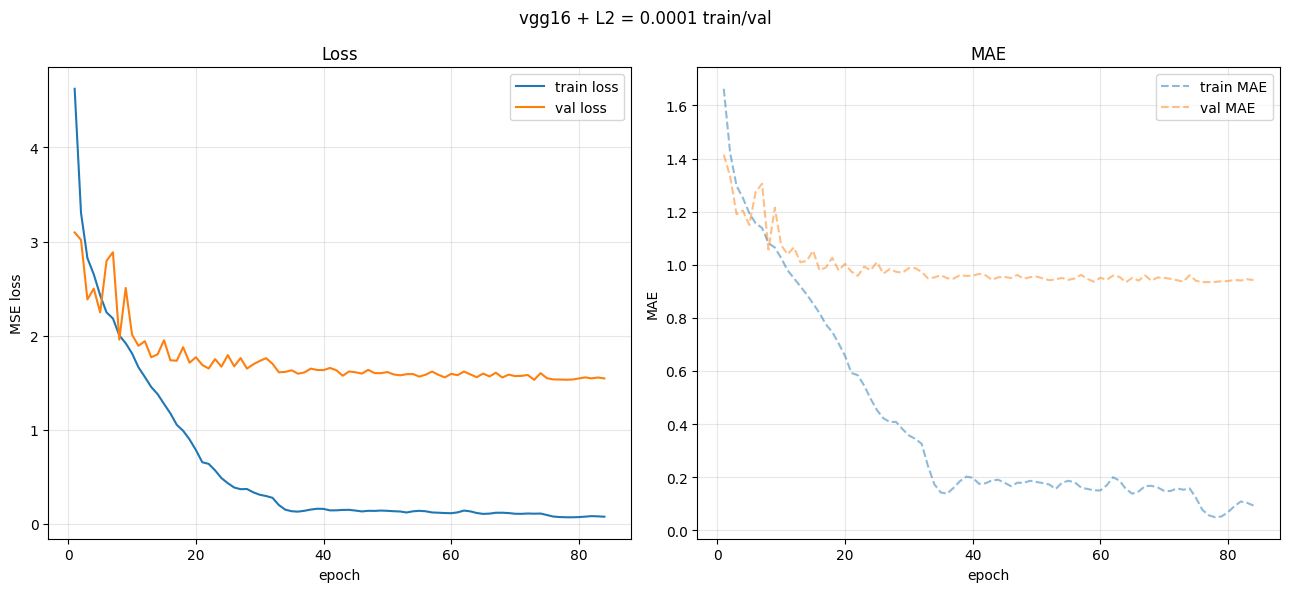

In [ ]:
from tensorflow.keras import callbacks
from tqdm import tqdm
vgg16_layers = [
    # Block 1
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 64,  "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [40,40,64] RF 6
    # Block 2
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 128, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [20,20,128] RF 16
    # Block 3
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 256, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [10,10,256] RF 44
    # Block 4
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "cnn", "out_channels": 512, "kernel_size": 3, "padding": "same", "initialization": "glorot_normal"},
    {"type": "activation", "name": "relu"},
    {"type": "maxpool", "pool_size": 2, "strides": 2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 + L2 = " + str(l2_rate)
)

## Batch norm + L2 + Xavier

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

Different Loss function

In [ ]:
def ranking_loss(y_true, y_pred):
    # build pairwise differences within batch
    y_true = tf.reshape(y_true, (-1,))
    y_pred = tf.reshape(y_pred, (-1,))
    y_diff  = tf.expand_dims(y_true, 1) - tf.expand_dims(y_true, 0)
    y_pred_diff = tf.expand_dims(y_pred, 1) - tf.expand_dims(y_pred, 0)
    mask = tf.cast(y_diff > 0, tf.float32)
    loss = tf.math.log1p(tf.exp(-y_pred_diff)) * mask   # logistic ranking
    return tf.reduce_mean(loss)

def attractiveness_loss(y_true, y_pred, alpha=1.0, beta=0.2):
    huber = tf.keras.losses.Huber(delta=1.0)(y_true, y_pred)
    rank  = ranking_loss(y_true, y_pred)
    return alpha * huber + beta * rank
def train_with_val(model,
                   train_ds_full,
                   val_ds_full,
                   epochs=100,
                   batch_size=32,
                   lr=1e-3,
                   name="model",
                   early_stop=True):
    train_ds = prepare_train(train_ds_full, batch_size=batch_size)
    val_ds   = prepare_val(val_ds_full, batch_size=batch_size)

    # Build once (subclassed model)
    x0, _ = next(iter(train_ds))
    _ = model(x0, training=True)

    # For debugging:
    for layer in model.layers:
      if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer:
        print(f"{layer.name}: L2 = {layer.kernel_regularizer.l2}")

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt, loss=attractiveness_loss,
        metrics=[
            tf.keras.metrics.MeanSquaredError(name="mse"),
            tf.keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
        ]
    )

    model.debug_initializers()

    cbs = [LivePlot(),SingleBar(), callbacks.TerminateOnNaN()]

    if early_stop:
        cbs += [
            callbacks.ReduceLROnPlateau(monitor="val_mean_absolute_error", factor=0.5, patience=10, min_lr=1e-6, verbose=1, mode='min'),
            callbacks.EarlyStopping(monitor="val_mean_absolute_error", patience=20, restore_best_weights=True, verbose=1, mode='min'),
        ]

    print(f"\n[train] {name} | lr={lr} | bs={batch_size} | epochs={epochs}")
    h = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        verbose=0,                 # SingleBar drives the progress
        callbacks=cbs
    ).history
    print(h["val_loss"])
    # summary
    last = {
        "loss": h["loss"][-1],
        "val_loss": h.get("val_loss", float("nan"))[-1],
        "mean_absolute_error": h.get("mean_absolute_error", [float("nan")])[-1],
        "val_mean_absolute_error": h.get("val_mean_absolute_error", [float("nan")])[-1],
    }
    print(last)
    print(f"[{name}] last: loss={last['loss']:.4f} | val_loss={last['val_loss']:.4f} | "
          f"rMAE={last['mean_absolute_error']:.4f} | val_rMAE={last['val_mean_absolute_error']:.4f}")

    # plot
    plot_train_val_history(h, title=f"{name} train/val")

    return h

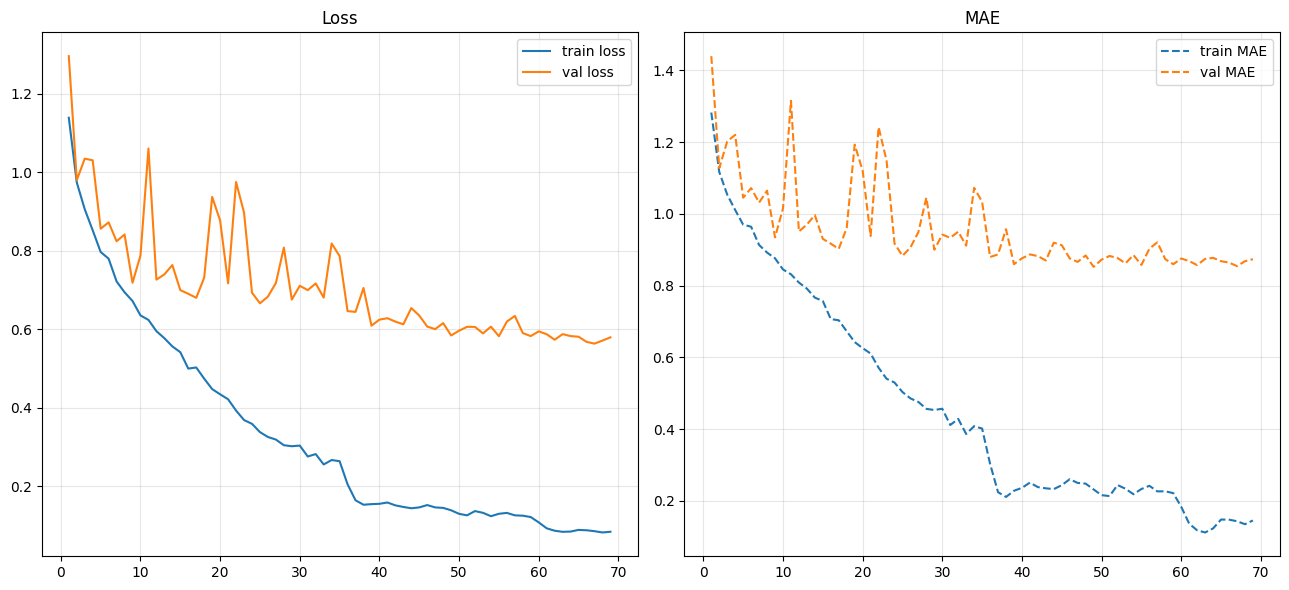

training:  46%|████▌      69/150 [04:41<05:08] , loss=0.0841, mse=0.0360


Epoch 69: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


Epoch 69: early stopping
Restoring model weights from the end of the best epoch: 49.


[1.2952338457107544, 0.9794371128082275, 1.0342086553573608, 1.029973030090332, 0.8557425737380981, 0.8719548583030701, 0.8238517045974731, 0.8411133885383606, 0.7181641459465027, 0.7876996994018555, 1.0599925518035889, 0.7260863184928894, 0.7395405173301697, 0.7631967067718506, 0.6993856430053711, 0.690024733543396, 0.6798664927482605, 0.7312392592430115, 0.9368466734886169, 0.8764551281929016, 0.7165640592575073, 0.9746302962303162, 0.8969181776046753, 0.6928470134735107, 0.6658680438995361, 0.6829909086227417, 0.7176135182380676, 0.8078030943870544, 0.6753182411193848, 0.7105580568313599, 0.6993306279182434, 0.7163946032524109, 0.6802094578742981, 0.818190336227417, 0.7860550880432129, 0.6459165215492249, 0.6440169215202332, 0.7049100995063782, 0.6089061498641968, 0.6242283582687378, 0.6279147863388062, 0.6192534565925598, 0.6123865246772766, 0.6536920666694641, 0.6345662474632263, 0.6066099405288696, 0.6000289916992188, 0.6154606938362122, 0.5839290618896484, 0.5960376262664795, 0.

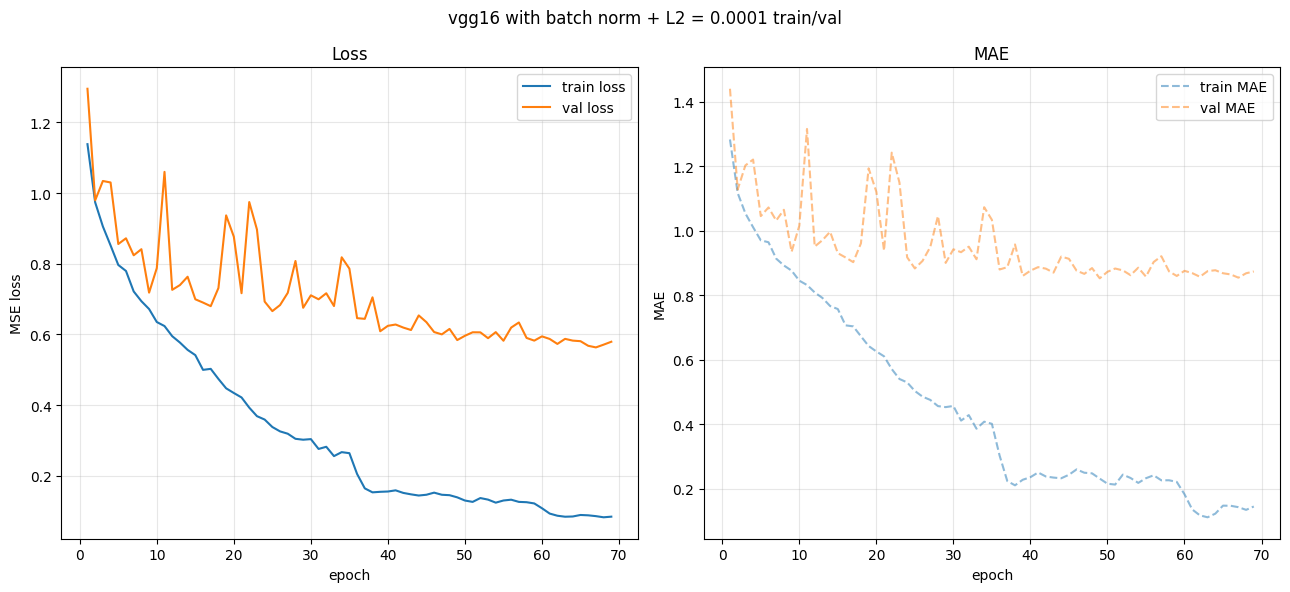

In [ ]:
vgg16_layers = [
    # Block 1
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":64,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},


    # Block 2
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":128,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 3
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":256,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},

    # Block 4
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"cnn","out_channels":512,"kernel_size":3,"padding":"same","initialization":"glorot_normal"},
    {"type":"batchnorm"}, {"type":"activation","name":"relu"},
    {"type":"maxpool","pool_size":2,"strides":2},
    # [5,5,512] RF 100
    # Block 5
    # In original VGG 16 They have 5 block with RF 220. We have 80x80 image that is more than enough. So we concluded directly with mlp
    {"type": "last_layer", "head_type": "fully_convolutional"}
     #
]

vgg16_layers = add_l2_to_layers(vgg16_layers, l2_rate=l2_rate)

vgg16_config = {
    "layers": vgg16_layers,
    "computation_sequence": "sequential"
}

vgg_model = AttractRegressorModel(vgg16_config)
hist_vgg = train_with_val(
    vgg_model, train_dataset, validation_dataset,
    epochs=general_epochs, batch_size=general_batch_size, lr=general_learning_rate, name="vgg16 with batch norm + L2 = " + str(l2_rate)
)

In [ ]:
vgg_model.save("model.keras")



# Evaluate a model on test dataset

In [ ]:
visualize_model(vgg_model)

Model: "attract_regressor_model_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (8, 80, 80, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_40 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (8, 80, 80, 64)        │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (8, 80, 80, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_41 (Activation)      │ (8, 80, 80, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (8, 40, 40, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (8, 40, 40, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_42 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (8, 40, 40, 128)       │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (8, 40, 40, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_43 (Activation)      │ (8, 40, 40, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (8, 20, 20, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (8, 20, 20, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_44 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (8, 20, 20, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_45 (Activation)      │ (8, 20, 20, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (8, 20, 20, 256)       │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (8, 20, 20, 256)       │         1,02

 Total params: 22,965,701 (87.61 MB)

 Trainable params: 7,653,441 (29.20 MB)

 Non-trainable params: 5,376 (21.00 KB)

 Optimizer params: 15,306,884 (58.39 MB)

In [ ]:
test_dataset = (
    tf.data.Dataset.list_files("test/*.jpg")
    .map(process_img, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(general_batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

results = vgg_model.evaluate(test_dataset, return_dict=True)
print("Test MSE:", results["mse"])
print("Test MAE:", results["mean_absolute_error"])


112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.2823 - mean_absolute_error: 0.8023 - mse: 1.1597
Test MSE: 1.122033953666687
Test MAE: 0.8041505813598633


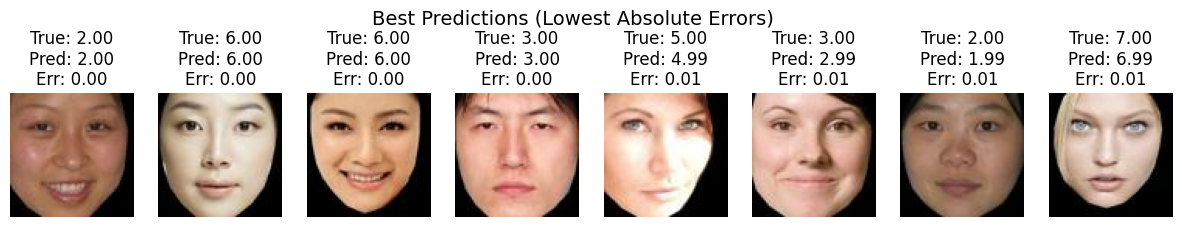

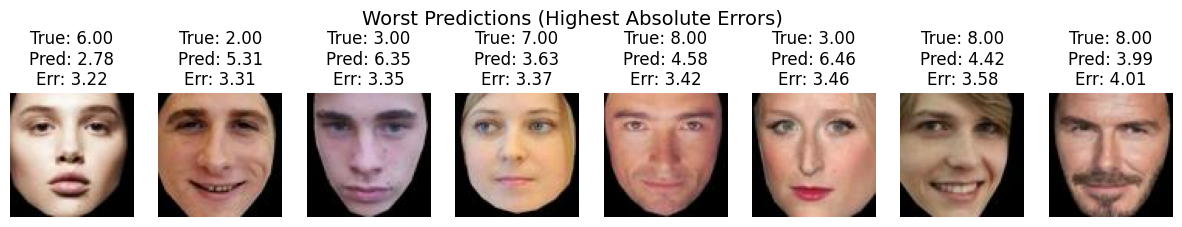

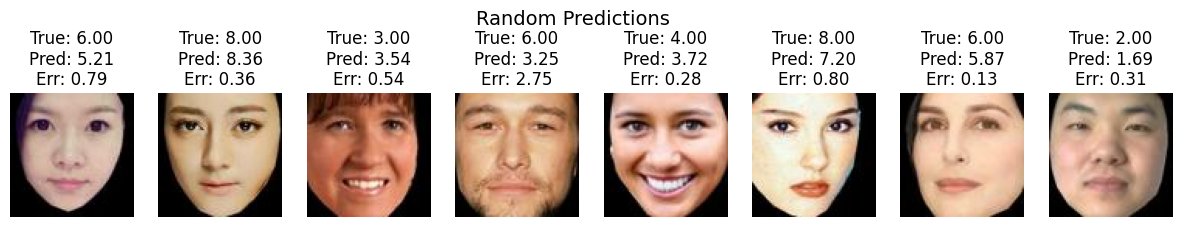

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def show_predictions(model, test_dataset, num_examples=5):
    # Collect all images, labels, and predictions
    all_images, all_labels, all_preds = [], [], []

    for batch_imgs, batch_labels in test_dataset:
        preds = model.predict(batch_imgs, verbose=0)
        all_images.append(batch_imgs.numpy())
        all_labels.append(batch_labels.numpy())
        all_preds.append(preds)

    # Concatenate everything
    all_images = np.concatenate(all_images)
    all_labels = np.concatenate(all_labels).flatten()
    all_preds = np.concatenate(all_preds).flatten()

    # Compute absolute errors
    errors = np.abs(all_preds - all_labels)
    sorted_idx = np.argsort(errors)

    # Choose subsets
    best_idx = sorted_idx[:num_examples]
    worst_idx = sorted_idx[-num_examples:]
    random_idx = np.random.choice(len(all_images), num_examples, replace=False)

    # Helper function to plot examples
    def plot_examples(indices, title):
        plt.figure(figsize=(15, 3))
        for i, idx in enumerate(indices):
            plt.subplot(1, num_examples, i + 1)
            plt.imshow(all_images[idx])
            plt.axis("off")
            plt.title(f"True: {all_labels[idx]:.2f}\nPred: {all_preds[idx]:.2f}\nErr: {errors[idx]:.2f}")
        plt.suptitle(title, fontsize=14)
        plt.show()

    # Show best, worst, and random predictions
    plot_examples(best_idx, f"Best Predictions (Lowest Absolute Errors)")
    plot_examples(worst_idx, f"Worst Predictions (Highest Absolute Errors)")
    plot_examples(random_idx, f"Random Predictions")

show_predictions(vgg_model, test_dataset, num_examples=8)